In [ ]:
# PREDRAFT STRATEGIES

In [17]:
"""
Category Importance Analysis - FantasyXI
=========================================
Analyze 2024 season data to determine which categories matter most for winning.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ============================================================================
# SECTION 1: LOAD DATA
# ============================================================================

# Load the Excel file
file_path = '/Users/gilrojasb/Desktop/Personal_Projects/NBA_Fantasy_2425/ESPN FANTASY IX BASKETBALL 2425.xlsx'

# Read Mother_tbl - team weekly stats
df_mother = pd.read_excel(file_path, sheet_name='Mother_tbl')
print("Mother_tbl shape:", df_mother.shape)
print("\nColumns:", df_mother.columns.tolist())
print("\nTeams:", df_mother['CODE'].unique())
print("Weeks:", df_mother['WEEK'].min(), "to", df_mother['WEEK'].max())

# Read Weekly_Matchups - head-to-head results
df_matchups = pd.read_excel(file_path, sheet_name='Weekly_Matchups')
print("\n\nWeekly_Matchups shape:", df_matchups.shape)
print("Sample:")
print(df_matchups.head())


# ============================================================================
# SECTION 2: CALCULATE CATEGORY WINS PER MATCHUP
# ============================================================================

# Categories to analyze (all 12 scoring categories)
categories = ['FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM']

def calculate_category_wins(week_num, team1_code, team2_code, df):
    """Calculate which team won each category in a specific matchup"""
    
    # Get team stats for this week
    team1_stats = df[(df['WEEK'] == week_num) & (df['CODE'] == team1_code)].iloc[0]
    team2_stats = df[(df['WEEK'] == week_num) & (df['CODE'] == team2_code)].iloc[0]
    
    results = {}
    for cat in categories:
        val1 = team1_stats[cat]
        val2 = team2_stats[cat]
        
        if val1 > val2:
            results[cat] = team1_code
        elif val2 > val1:
            results[cat] = team2_code
        else:
            results[cat] = 'TIE'
    
    return results

# Build matchup pairs from Weekly_Matchups sheet
# Assuming structure: each pair of rows is a matchup
matchup_results = []

for week in range(1, 19):  # 18 weeks
    week_data = df_matchups[df_matchups['WEEK'] == week]
    
    # Process pairs (every 2 rows is one matchup)
    for i in range(0, len(week_data), 2):
        if i+1 < len(week_data):
            team1 = week_data.iloc[i]
            team2 = week_data.iloc[i+1]
            
            # Calculate category wins
            cat_wins = calculate_category_wins(week, team1['CODE'], team2['CODE'], df_mother)
            
            # Count wins for each team
            team1_wins = sum(1 for winner in cat_wins.values() if winner == team1['CODE'])
            team2_wins = sum(1 for winner in cat_wins.values() if winner == team2['CODE'])
            
            matchup_results.append({
                'week': week,
                'team1': team1['CODE'],
                'team2': team2['CODE'],
                'team1_cat_wins': team1_wins,
                'team2_cat_wins': team2_wins,
                'winner': team1['CODE'] if team1_wins > team2_wins else team2['CODE'],
                **{f"{cat}_winner": cat_wins[cat] for cat in categories}
            })

df_results = pd.DataFrame(matchup_results)
print("\n\nMatchup Results:")
print(df_results.head(10))


# ============================================================================
# SECTION 3: CATEGORY IMPORTANCE ANALYSIS
# ============================================================================

# Calculate how often each category determined the matchup winner
category_importance = {}

for cat in categories:
    col_name = f"{cat}_winner"
    
    # Count how many times winning this category = winning the matchup
    decisive_wins = 0
    total_matchups = len(df_results)
    
    for idx, row in df_results.iterrows():
        cat_winner = row[col_name]
        matchup_winner = row['winner']
        
        if cat_winner == matchup_winner and cat_winner != 'TIE':
            decisive_wins += 1
    
    category_importance[cat] = {
        'decisive_win_rate': decisive_wins / total_matchups,
        'decisive_wins': decisive_wins
    }

df_importance = pd.DataFrame(category_importance).T.sort_values('decisive_win_rate', ascending=False)
print("\n\n=== CATEGORY IMPORTANCE (by correlation with matchup wins) ===")
print(df_importance)


# ============================================================================
# SECTION 4: VISUALIZATIONS
# ============================================================================

# Plot 1: Category Importance Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#FF4444' if val > 0.65 else '#4444FF' if val > 0.55 else '#888888' 
          for val in df_importance['decisive_win_rate']]
df_importance['decisive_win_rate'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Correlation with Matchup Wins', fontsize=12, fontweight='bold')
ax.set_ylabel('Category', fontsize=12, fontweight='bold')
ax.set_title('Category Importance: Which Stats Win Matchups?', fontsize=16, fontweight='bold')
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, label='50% baseline')
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: outputs/category_importance.png")


# Plot 2: Category Win Distribution
category_win_counts = {}
for cat in categories:
    col_name = f"{cat}_winner"
    win_counts = df_results[col_name].value_counts()
    category_win_counts[cat] = win_counts

fig, ax = plt.subplots(figsize=(16, 10))
teams = df_mother['CODE'].unique()
category_data = []

for cat in categories:
    cat_col = f"{cat}_winner"
    for team in teams:
        wins = (df_results[cat_col] == team).sum()
        category_data.append({'Category': cat, 'Team': team, 'Wins': wins})

df_cat_dist = pd.DataFrame(category_data)
pivot_table = df_cat_dist.pivot(index='Category', columns='Team', values='Wins')
pivot_table.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Category Wins', fontsize=12, fontweight='bold')
ax.set_ylabel('Category', fontsize=12, fontweight='bold')
ax.set_title('Category Win Distribution by Team (2024 Season)', fontsize=16, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../outputs/category_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_distribution.png")


# ============================================================================
# SECTION 5: TEAM PERFORMANCE BY CATEGORY
# ============================================================================

# Calculate season totals by team
team_season_totals = df_mother.groupby('CODE')[categories].mean()
team_final_records = df_results.groupby('winner').size().sort_values(ascending=False)

print("\n\n=== TEAM SEASON AVERAGES ===")
print(team_season_totals.round(3))

print("\n\n=== FINAL STANDINGS (by matchup wins) ===")
print(team_final_records)


# ============================================================================
# SECTION 6: CATEGORY CORRELATION MATRIX
# ============================================================================

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Category Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/category_correlation.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation.png")


# ============================================================================
# SECTION 7: KEY INSIGHTS
# ============================================================================

print("\n\n" + "="*70)
print("KEY INSIGHTS - CATEGORY IMPORTANCE FOR 2025 DRAFT")
print("="*70)

top_3 = df_importance.head(3)
bottom_3 = df_importance.tail(3)

print("\n🔥 MOST IMPORTANT CATEGORIES (Must-Win):")
for idx, (cat, row) in enumerate(top_3.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['decisive_win_rate']:.1%} correlation with matchup wins")

print("\n📊 LEAST IMPORTANT CATEGORIES (Puntable):")
for idx, (cat, row) in enumerate(bottom_3.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['decisive_win_rate']:.1%} correlation with matchup wins")

print("\n💡 DRAFT STRATEGY RECOMMENDATIONS:")
print("  • Focus on:", ", ".join(top_3.index.tolist()))
print("  • Can punt:", ", ".join(bottom_3.index.tolist()))
print("  • Highly correlated pairs:", end=" ")

# Find highly correlated categories (r > 0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append(f"{corr_matrix.columns[i]}-{corr_matrix.columns[j]}")
print(", ".join(high_corr_pairs) if high_corr_pairs else "None found")

print("\n" + "="*70)
print("\n✅ Analysis complete! Check outputs/ folder for visualizations.")

Mother_tbl shape: (180, 14)

Columns: ['CODE', 'FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM', 'WEEK']

Teams: ['ROJA' 'HERN' 'SKY' 'Mmg' 'WARi' 'GNKI' 'KOBE' 'RIZY' 'FFT' 'AAT']
Weeks: 1 to 18


Weekly_Matchups shape: (248, 32)
Sample:
  ESPN FANTASY IX BASKETBALL 24/25 Unnamed: 1 Unnamed: 2 Unnamed: 3  \
0                              NaN        NaN        NaN        NaN   
1                              NaN        NaN        NaN        NaN   
2                              NaN        NaN        NaN        NaN   
3                              NaN        NaN       CODE        FGM   
4                           WEEK 1    MATCH 1       ROJA        232   

  Unnamed: 4 Unnamed: 5 Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ...  \
0        NaN        NaN        NaN        NaN        NaN        NaN  ...   
1        NaN        NaN        NaN        NaN        NaN        NaN  ...   
2        NaN        NaN        NaN        NaN        NaN        NaN  ...

KeyError: 'WEEK'

Mother_tbl shape: (180, 14)

Columns: ['CODE', 'FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM', 'WEEK']

Teams: ['ROJA' 'HERN' 'SKY' 'Mmg' 'WARi' 'GNKI' 'KOBE' 'RIZY' 'FFT' 'AAT']
Weeks: 1 to 18

=== Week 1 Matchup Structure ===
Teams in Week 1: 10 (should be 10)
Order:
  0: ROJA
  1: HERN
  2: SKY
  3: Mmg
  4: WARi
  5: GNKI
  6: KOBE
  7: RIZY
  8: FFT
  9: AAT

Matchups should be:
  Row 0 vs Row 1
  Row 2 vs Row 3
  Row 4 vs Row 5
  Row 6 vs Row 7
  Row 8 vs Row 9


=== MATCHUP RESULTS ===
Total matchups: 90
Expected: 90 = 90 matchups

First 5 matchups (Week 1):
   week team1 team2  team1_cat_wins  team2_cat_wins winner
0     1  ROJA  HERN              11               1   ROJA
1     1   SKY   Mmg              10               2    SKY
2     1  WARi  GNKI               9               3   WARi
3     1  KOBE  RIZY               8               4   KOBE
4     1   FFT   AAT               3               9    AAT


=== CATEGORY IMPORTANCE (Correlation

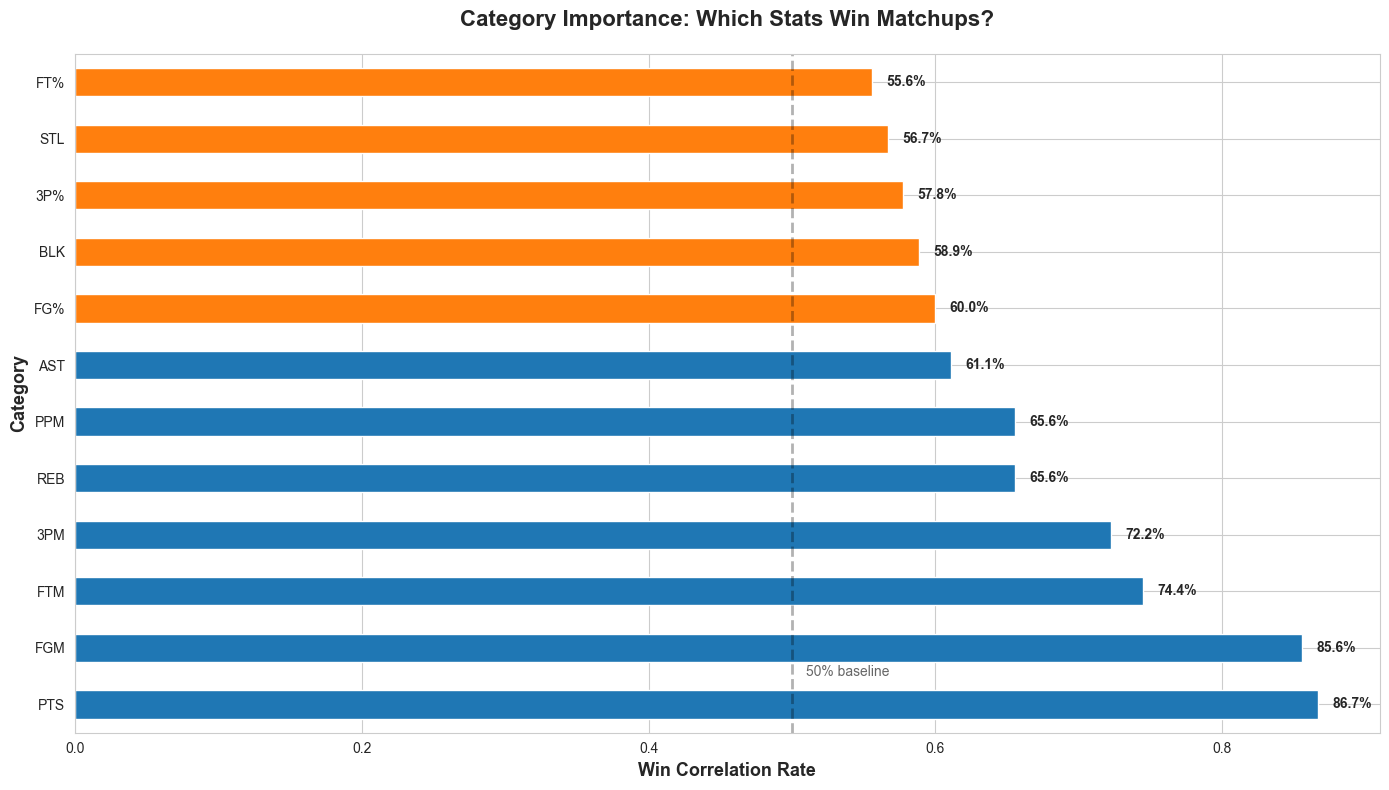

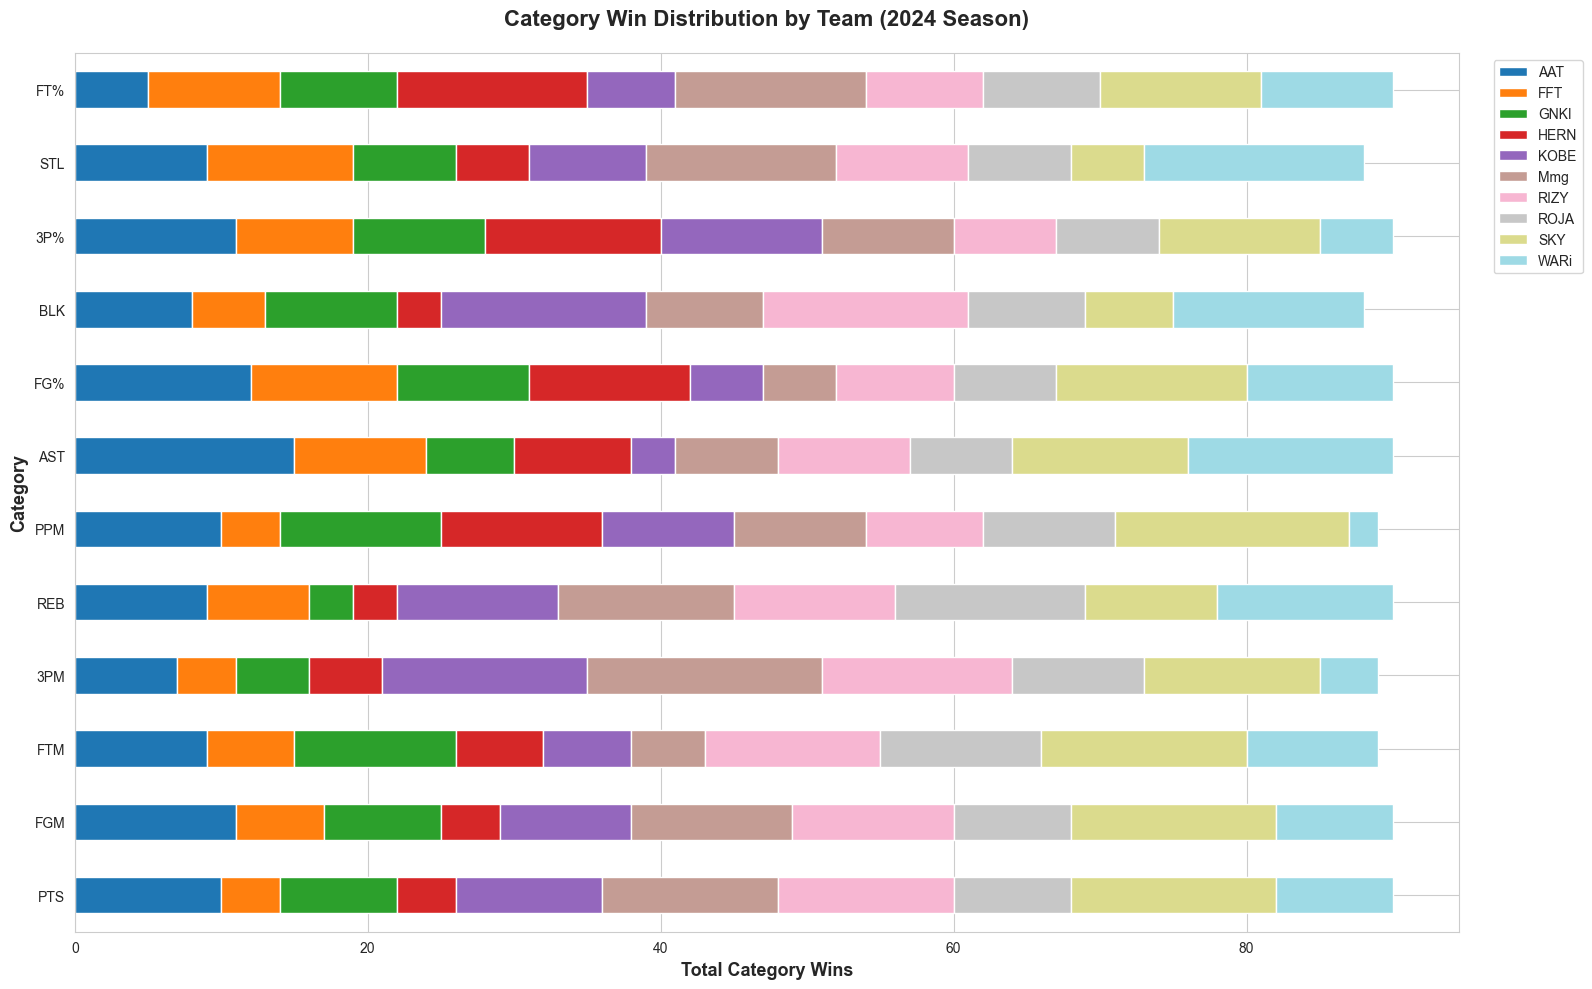

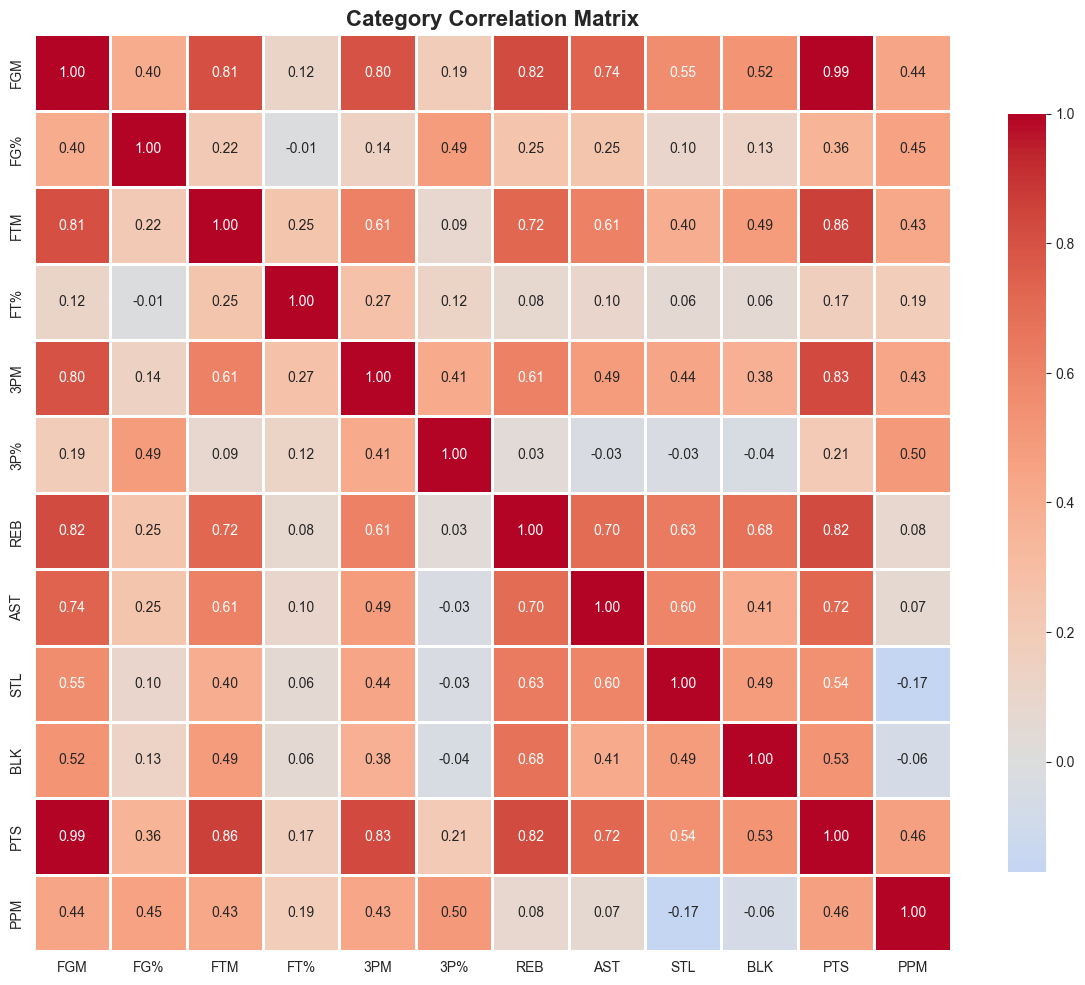

In [18]:
"""
Category Importance Analysis - FantasyXI
=========================================
Analyze 2024 season data to determine which categories matter most for winning.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ============================================================================
# SECTION 1: LOAD DATA
# ============================================================================

# Load the Excel file
file_path = '/Users/gilrojasb/Desktop/Personal_Projects/NBA_Fantasy_2425/ESPN FANTASY IX BASKETBALL 2425.xlsx'

# Read Mother_tbl - team weekly stats (organized as alternating matchups)
df_mother = pd.read_excel(file_path, sheet_name='Mother_tbl')
print("Mother_tbl shape:", df_mother.shape)
print("\nColumns:", df_mother.columns.tolist())
print("\nTeams:", df_mother['CODE'].unique())
print("Weeks:", df_mother['WEEK'].min(), "to", df_mother['WEEK'].max())

# Verify matchup structure
print("\n=== Week 1 Matchup Structure ===")
week1 = df_mother[df_mother['WEEK'] == 1]
print(f"Teams in Week 1: {len(week1)} (should be 10)")
print("Order:")
for idx, row in week1.iterrows():
    print(f"  {idx}: {row['CODE']}")
print("\nMatchups should be:")
print("  Row 0 vs Row 1")
print("  Row 2 vs Row 3")
print("  Row 4 vs Row 5")
print("  Row 6 vs Row 7")
print("  Row 8 vs Row 9")


# ============================================================================
# SECTION 2: EXTRACT MATCHUPS AND CALCULATE CATEGORY WINS
# ============================================================================

# Categories to analyze (all 12 scoring categories)
categories = ['FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM']

def calculate_category_wins(team1_stats, team2_stats):
    """Calculate which team won each category"""
    results = {}
    for cat in categories:
        val1 = team1_stats[cat]
        val2 = team2_stats[cat]
        
        if val1 > val2:
            results[cat] = 1  # Team 1 wins
        elif val2 > val1:
            results[cat] = 2  # Team 2 wins
        else:
            results[cat] = 0  # Tie
    
    return results

# Process all matchups (alternating pairs within each week)
matchup_results = []

for week in range(1, 19):  # 18 weeks
    week_data = df_mother[df_mother['WEEK'] == week].reset_index(drop=True)
    
    # Process pairs: rows 0-1, 2-3, 4-5, 6-7, 8-9
    for i in range(0, len(week_data), 2):
        if i+1 < len(week_data):
            team1 = week_data.iloc[i]
            team2 = week_data.iloc[i+1]
            
            # Calculate category wins
            cat_wins = calculate_category_wins(team1, team2)
            
            # Count total category wins
            team1_cat_wins = sum(1 for v in cat_wins.values() if v == 1)
            team2_cat_wins = sum(1 for v in cat_wins.values() if v == 2)
            
            # Determine matchup winner
            if team1_cat_wins > team2_cat_wins:
                winner = team1['CODE']
                loser = team2['CODE']
            elif team2_cat_wins > team1_cat_wins:
                winner = team2['CODE']
                loser = team1['CODE']
            else:
                winner = 'TIE'
                loser = 'TIE'
            
            # Store results
            matchup_results.append({
                'week': week,
                'team1': team1['CODE'],
                'team2': team2['CODE'],
                'team1_cat_wins': team1_cat_wins,
                'team2_cat_wins': team2_cat_wins,
                'winner': winner,
                'loser': loser,
                **{f"{cat}_winner": cat_wins[cat] for cat in categories}
            })

df_results = pd.DataFrame(matchup_results)
print("\n\n=== MATCHUP RESULTS ===")
print(f"Total matchups: {len(df_results)}")
print(f"Expected: {18 * 5} = 90 matchups")
print("\nFirst 5 matchups (Week 1):")
print(df_results.head()[['week', 'team1', 'team2', 'team1_cat_wins', 'team2_cat_wins', 'winner']])


# ============================================================================
# SECTION 3: CATEGORY IMPORTANCE ANALYSIS
# ============================================================================

# Calculate how often winning each category correlated with winning the matchup
category_importance = {}

for cat in categories:
    col_name = f"{cat}_winner"
    
    # Count decisive matchups where this category mattered
    decisive_for_winner = 0
    decisive_for_loser = 0
    ties = 0
    
    for idx, row in df_results.iterrows():
        cat_winner = row[col_name]  # 1 = team1, 2 = team2, 0 = tie
        matchup_winner = row['winner']
        
        if cat_winner == 0:
            ties += 1
        elif (cat_winner == 1 and matchup_winner == row['team1']) or \
             (cat_winner == 2 and matchup_winner == row['team2']):
            decisive_for_winner += 1
        else:
            decisive_for_loser += 1
    
    total_matchups = len(df_results)
    
    category_importance[cat] = {
        'win_correlation': decisive_for_winner / total_matchups,
        'loss_correlation': decisive_for_loser / total_matchups,
        'tie_rate': ties / total_matchups,
        'decisive_wins': decisive_for_winner,
        'decisive_losses': decisive_for_loser
    }

df_importance = pd.DataFrame(category_importance).T.sort_values('win_correlation', ascending=False)
print("\n\n=== CATEGORY IMPORTANCE (Correlation with Matchup Wins) ===")
print(df_importance[['win_correlation', 'loss_correlation', 'tie_rate']].round(3))

# Calculate overall team records
team_records = {}
for team in df_mother['CODE'].unique():
    wins = ((df_results['winner'] == team)).sum()
    losses = ((df_results['loser'] == team)).sum()
    team_records[team] = {'wins': wins, 'losses': losses, 'win_pct': wins / (wins + losses) if (wins + losses) > 0 else 0}

df_records = pd.DataFrame(team_records).T.sort_values('win_pct', ascending=False)
print("\n\n=== FINAL STANDINGS (2024 Season) ===")
df_records['record'] = df_records['wins'].astype(str) + '-' + df_records['losses'].astype(str)
print(df_records[['record', 'win_pct']].round(3))


# ============================================================================
# SECTION 4: VISUALIZATIONS
# ============================================================================

# Plot 1: Category Importance Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#1f77b4' if val > 0.60 else '#ff7f0e' if val > 0.50 else '#d62728' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Importance: Which Stats Win Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

# Add value labels
for i, v in enumerate(df_importance['win_correlation']):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: outputs/category_importance.png")


# Plot 2: Category Win Distribution by Team
category_win_counts = {cat: {} for cat in categories}

for idx, row in df_results.iterrows():
    for cat in categories:
        cat_col = f"{cat}_winner"
        winner_code = row[cat_col]
        
        if winner_code == 1:
            team = row['team1']
        elif winner_code == 2:
            team = row['team2']
        else:
            continue  # Skip ties
        
        if team not in category_win_counts[cat]:
            category_win_counts[cat][team] = 0
        category_win_counts[cat][team] += 1

# Convert to DataFrame for plotting
cat_dist_data = []
for cat in categories:
    for team, wins in category_win_counts[cat].items():
        cat_dist_data.append({'Category': cat, 'Team': team, 'Wins': wins})

df_cat_dist = pd.DataFrame(cat_dist_data)
pivot_table = df_cat_dist.pivot(index='Category', columns='Team', values='Wins').fillna(0)

# Reorder by importance
pivot_table = pivot_table.reindex(df_importance.index)

fig, ax = plt.subplots(figsize=(16, 10))
pivot_table.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Category Wins', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Win Distribution by Team (2024 Season)', fontsize=16, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/category_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_distribution.png")


# ============================================================================
# SECTION 5: TEAM PERFORMANCE BY CATEGORY
# ============================================================================

# Calculate season totals by team
team_season_totals = df_mother.groupby('CODE')[categories].mean()
team_final_records = df_results.groupby('winner').size().sort_values(ascending=False)

print("\n\n=== TEAM SEASON AVERAGES ===")
print(team_season_totals.round(3))

print("\n\n=== FINAL STANDINGS (by matchup wins) ===")
print(team_final_records)


# ============================================================================
# SECTION 6: CATEGORY CORRELATION MATRIX
# ============================================================================

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Category Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/category_correlation.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation.png")


# ============================================================================
# SECTION 7: KEY INSIGHTS & DRAFT STRATEGY
# ============================================================================

print("\n\n" + "="*80)
print("🏀 KEY INSIGHTS - CATEGORY IMPORTANCE FOR 2025 DRAFT 🏀")
print("="*80)

top_5 = df_importance.head(5)
bottom_5 = df_importance.tail(5)

print("\n🔥 MOST IMPORTANT CATEGORIES (Must-Win):")
for idx, (cat, row) in enumerate(top_5.iterrows(), 1):
    print(f"  {idx}. **{cat}**: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

print("\n📊 LEAST IMPORTANT CATEGORIES (Puntable):")
for idx, (cat, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

# Find highly correlated categories
print("\n🔗 HIGHLY CORRELATED CATEGORIES (Move Together):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for cat1, cat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"  • {cat1} ↔ {cat2}: {corr_val:.2f} correlation")
else:
    print("  • No strong correlations found (r > 0.7)")

# Identify champion's category profile
champion = df_records.index[0]
champion_stats = df_mother[df_mother['CODE'] == champion][categories].mean()

print(f"\n👑 CHAMPION PROFILE ({champion}):")
print(f"  Record: {df_records.loc[champion, 'record']} ({df_records.loc[champion, 'win_pct']:.1%})")
print(f"\n  Strong Categories (Top 3 vs league average):")

# Calculate league averages
league_avg = df_mother[categories].mean()
champion_vs_league = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

for cat in champion_vs_league.head(3).index:
    pct_diff = champion_vs_league[cat]
    print(f"    • {cat}: +{pct_diff:.1f}% vs league avg")

print("\n💡 2025 DRAFT STRATEGY RECOMMENDATIONS:")
print(f"  1. Target: {', '.join(top_5.index[:3].tolist())} (highest win correlation)")
print(f"  2. Avoid punting: {top_5.index[0]} (critical category)")
print(f"  3. Can safely punt: {', '.join(bottom_5.index[:2].tolist())} (lowest impact)")
print(f"  4. Build around: {champion}'s blueprint - strong in {', '.join(champion_vs_league.head(3).index.tolist())}")

if high_corr_pairs:
    pair = high_corr_pairs[0]
    print(f"  5. Get 2-for-1 value: Target players strong in {pair[0]} (also helps {pair[1]})")

print("\n" + "="*80)
print("✅ Analysis complete! Review visualizations in outputs/ folder")
print("="*80)

FANTASY XI - ADVANCED CATEGORY ANALYSIS

Data loaded: 180 team-weeks across 18 weeks
Teams: ROJA, HERN, SKY, Mmg, WARi, GNKI, KOBE, RIZY, FFT, AAT

=== Matchup Structure Verification ===
Week 1 teams: 10 (Expected: 10)
Matchup pairs: 0-1, 2-3, 4-5, 6-7, 8-9 ✓

✓ Processed 90 matchups

SECTION 1: CATEGORY IMPORTANCE METRICS

📊 CATEGORY IMPORTANCE RANKINGS
--------------------------------------------------------------------------------
Category Win Corr   Avg Margin   Volatility   Close Rate
--------------------------------------------------------------------------------
PTS         86.7%       117.3        83.2     25.6%
FGM         85.6%        44.3        32.4     24.7%
FTM         74.4%        25.7        16.1     23.9%
3PM         72.2%        18.9        12.5     24.6%
REB         65.6%        57.7        36.1     25.4%
PPM         65.6%         0.1         0.0     25.4%
AST         61.1%        42.2        24.2     25.5%
FG%         60.0%         0.0         0.0     25.9%
BLK     

KeyError: 'record'

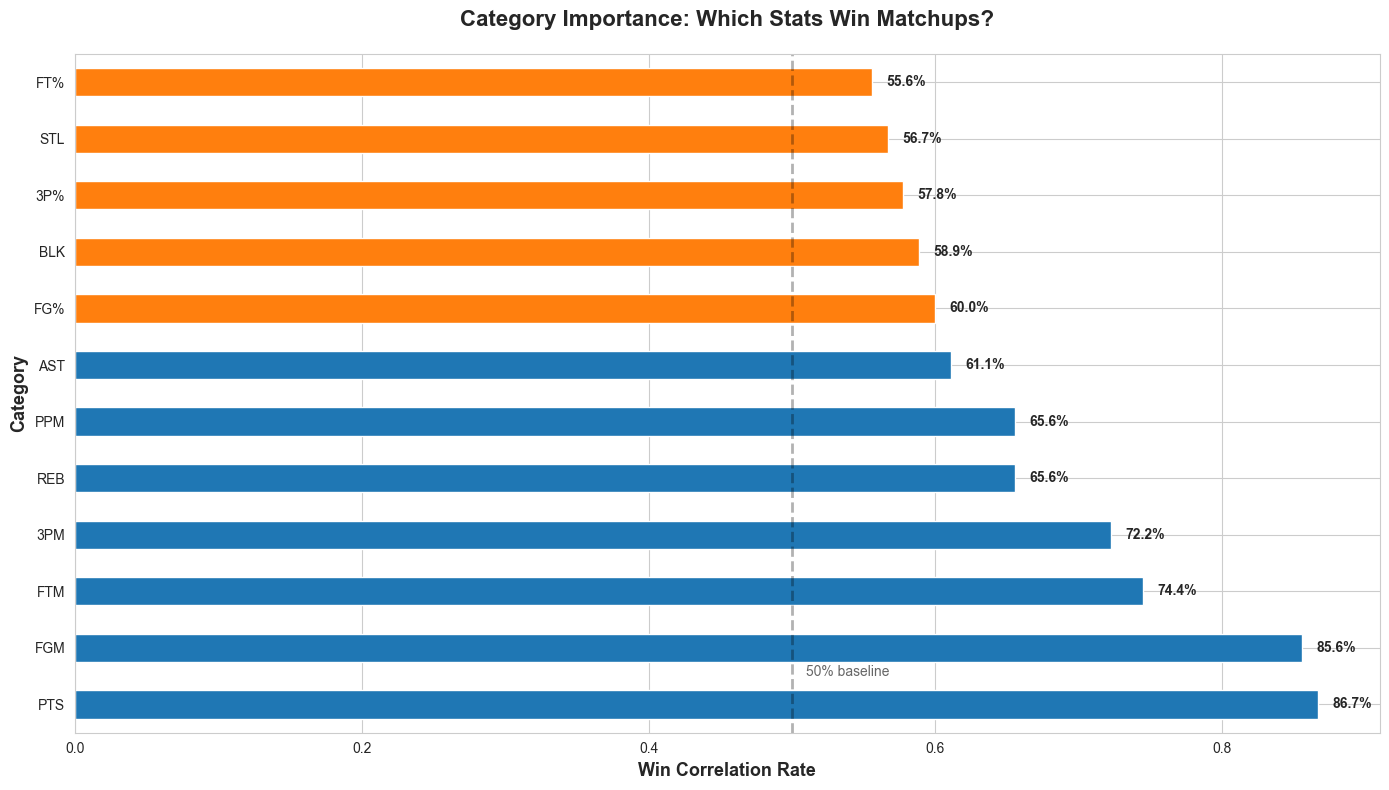

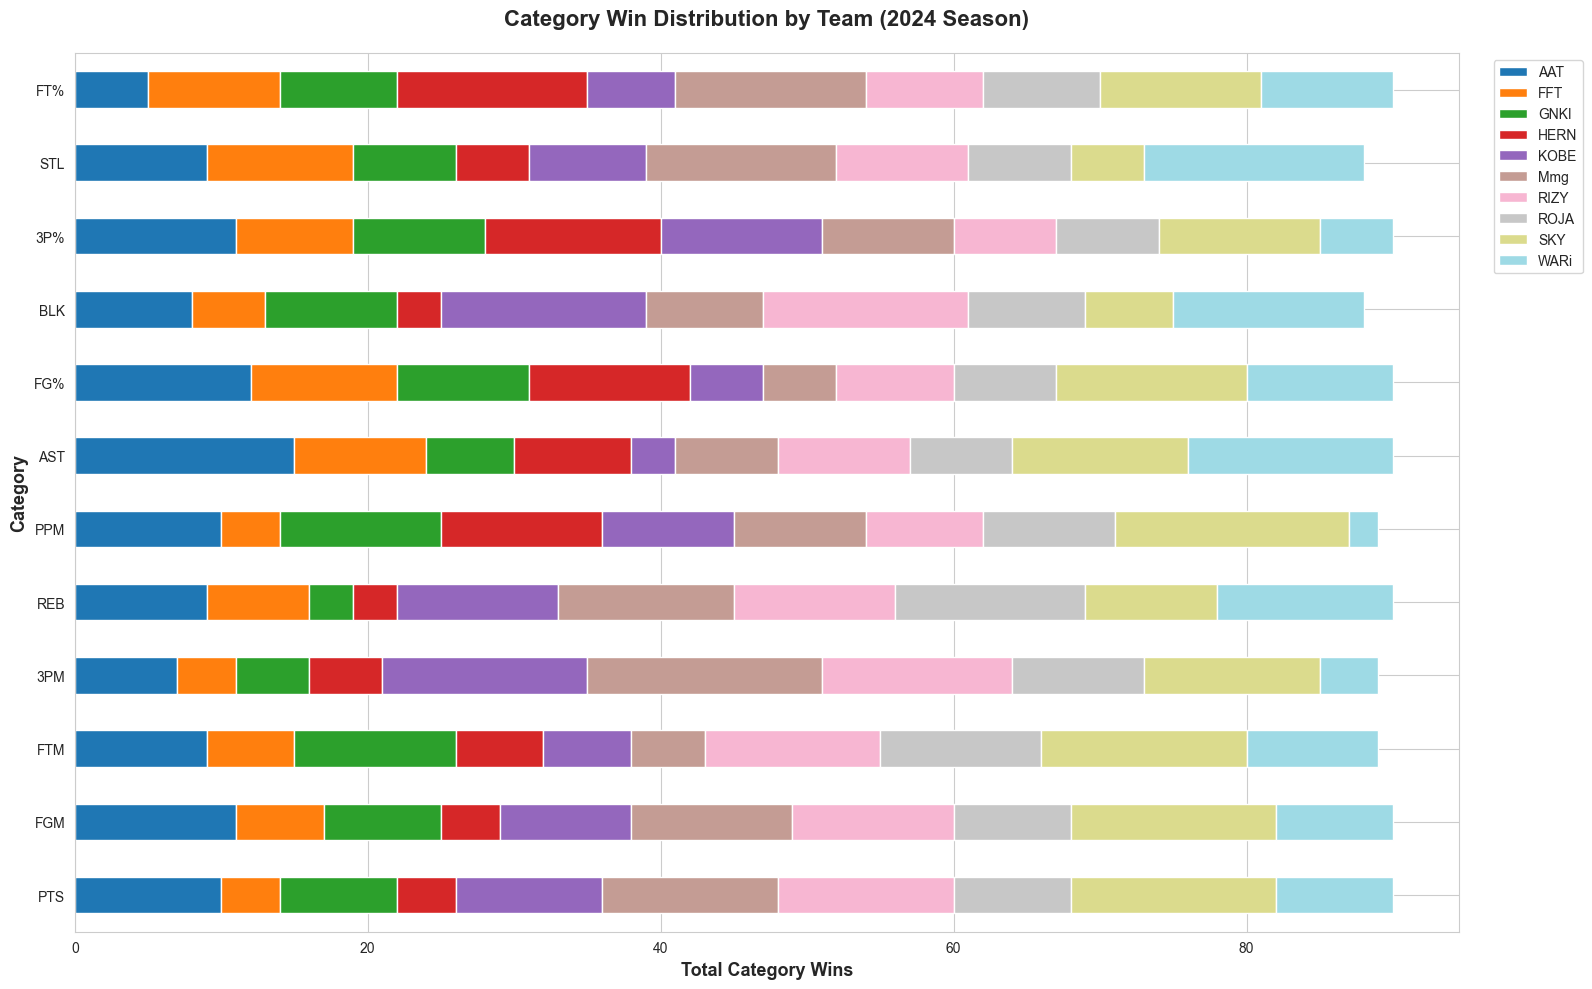

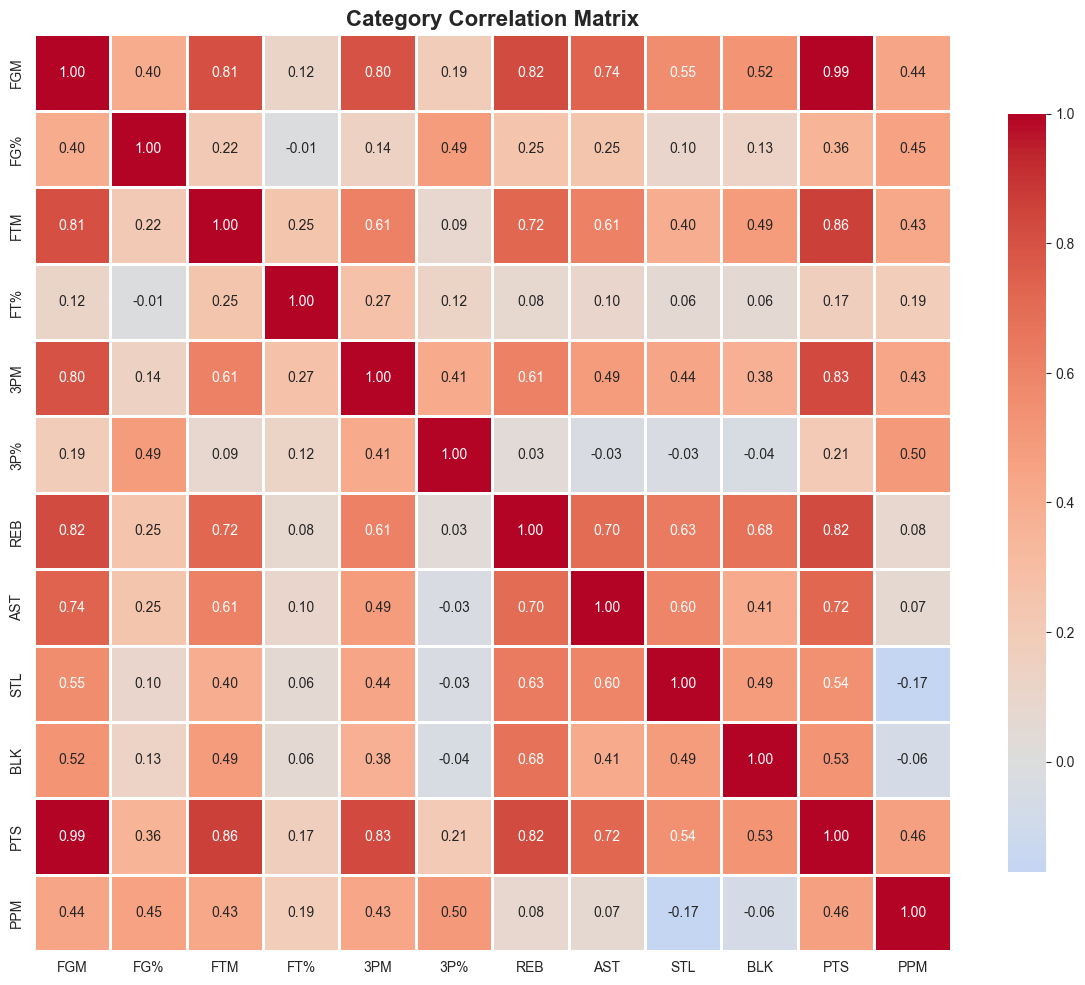

In [30]:
"""
Category Importance Analysis - FantasyXI (ENHANCED)
====================================================
Deep dive into matchups and category relevancy for draft strategy optimization.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ============================================================================
# SECTION 1: LOAD DATA
# ============================================================================

# Load the Excel file
file_path = '/Users/gilrojasb/Desktop/Personal_Projects/NBA_Fantasy_2425/ESPN FANTASY IX BASKETBALL 2425.xlsx'

# Read Mother_tbl - team weekly stats (organized as alternating matchups)
df_mother = pd.read_excel(file_path, sheet_name='Mother_tbl')
print("="*80)
print("FANTASY XI - ADVANCED CATEGORY ANALYSIS")
print("="*80)
print(f"\nData loaded: {df_mother.shape[0]} team-weeks across {df_mother['WEEK'].max()} weeks")
print(f"Teams: {', '.join(df_mother['CODE'].unique())}")

# Verify matchup structure
print("\n=== Matchup Structure Verification ===")
week1 = df_mother[df_mother['WEEK'] == 1]
print(f"Week 1 teams: {len(week1)} (Expected: 10)")
print("Matchup pairs: 0-1, 2-3, 4-5, 6-7, 8-9 ✓")


# ============================================================================
# SECTION 2: EXTRACT MATCHUPS AND CALCULATE CATEGORY WINS
# ============================================================================

# Categories to analyze (all 12 scoring categories)
categories = ['FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM']

def calculate_category_wins(team1_stats, team2_stats):
    """Calculate which team won each category"""
    results = {}
    margins = {}
    for cat in categories:
        val1 = team1_stats[cat]
        val2 = team2_stats[cat]
        
        if val1 > val2:
            results[cat] = 1  # Team 1 wins
            margins[cat] = val1 - val2
        elif val2 > val1:
            results[cat] = 2  # Team 2 wins
            margins[cat] = val2 - val1
        else:
            results[cat] = 0  # Tie
            margins[cat] = 0
    
    return results, margins

# Process all matchups (alternating pairs within each week)
matchup_results = []

for week in range(1, 19):  # 18 weeks
    week_data = df_mother[df_mother['WEEK'] == week].reset_index(drop=True)
    
    # Process pairs: rows 0-1, 2-3, 4-5, 6-7, 8-9
    for i in range(0, len(week_data), 2):
        if i+1 < len(week_data):
            team1 = week_data.iloc[i]
            team2 = week_data.iloc[i+1]
            
            # Calculate category wins and margins
            cat_wins, cat_margins = calculate_category_wins(team1, team2)
            
            # Count total category wins
            team1_cat_wins = sum(1 for v in cat_wins.values() if v == 1)
            team2_cat_wins = sum(1 for v in cat_wins.values() if v == 2)
            
            # Determine matchup winner
            if team1_cat_wins > team2_cat_wins:
                winner = team1['CODE']
                loser = team2['CODE']
                win_margin = team1_cat_wins - team2_cat_wins
            elif team2_cat_wins > team1_cat_wins:
                winner = team2['CODE']
                loser = team1['CODE']
                win_margin = team2_cat_wins - team1_cat_wins
            else:
                winner = 'TIE'
                loser = 'TIE'
                win_margin = 0
            
            # Store results with margins
            matchup_results.append({
                'week': week,
                'team1': team1['CODE'],
                'team2': team2['CODE'],
                'team1_cat_wins': team1_cat_wins,
                'team2_cat_wins': team2_cat_wins,
                'winner': winner,
                'loser': loser,
                'win_margin': win_margin,
                **{f"{cat}_winner": cat_wins[cat] for cat in categories},
                **{f"{cat}_margin": cat_margins[cat] for cat in categories}
            })

df_results = pd.DataFrame(matchup_results)
print(f"\n✓ Processed {len(df_results)} matchups")


# ============================================================================
# SECTION 3: ENHANCED CATEGORY IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: CATEGORY IMPORTANCE METRICS")
print("="*80)

# Calculate comprehensive category importance metrics
category_metrics = {}

for cat in categories:
    col_name = f"{cat}_winner"
    margin_col = f"{cat}_margin"
    
    # Basic win correlation
    decisive_for_winner = 0
    decisive_for_loser = 0
    ties = 0
    
    # Margin analysis
    winning_margins = []
    losing_margins = []
    
    for idx, row in df_results.iterrows():
        cat_winner = row[col_name]  # 1 = team1, 2 = team2, 0 = tie
        matchup_winner = row['winner']
        margin = row[margin_col]
        
        if cat_winner == 0:
            ties += 1
        elif (cat_winner == 1 and matchup_winner == row['team1']) or \
             (cat_winner == 2 and matchup_winner == row['team2']):
            decisive_for_winner += 1
            winning_margins.append(margin)
        else:
            decisive_for_loser += 1
            losing_margins.append(margin)
    
    total_matchups = len(df_results)
    
    # Calculate comprehensive metrics
    category_metrics[cat] = {
        'win_correlation': decisive_for_winner / total_matchups,
        'loss_correlation': decisive_for_loser / total_matchups,
        'tie_rate': ties / total_matchups,
        'avg_winning_margin': np.mean(winning_margins) if winning_margins else 0,
        'avg_losing_margin': np.mean(losing_margins) if losing_margins else 0,
        'margin_stdev': np.std(winning_margins + losing_margins) if (winning_margins + losing_margins) else 0,
        'decisive_wins': decisive_for_winner,
        'decisive_losses': decisive_for_loser,
        'close_matchup_rate': sum(1 for m in winning_margins if m < np.percentile(winning_margins, 25)) / len(winning_margins) if winning_margins else 0
    }

df_importance = pd.DataFrame(category_metrics).T.sort_values('win_correlation', ascending=False)

print("\n📊 CATEGORY IMPORTANCE RANKINGS")
print("-" * 80)
print(f"{'Category':<8} {'Win Corr':<10} {'Avg Margin':<12} {'Volatility':<12} {'Close Rate':<10}")
print("-" * 80)
for cat, row in df_importance.iterrows():
    print(f"{cat:<8} {row['win_correlation']:>8.1%}  {row['avg_winning_margin']:>10.1f}  {row['margin_stdev']:>10.1f}  {row['close_matchup_rate']:>8.1%}")


# ============================================================================
# SECTION 4: MATCHUP TIGHTNESS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: MATCHUP COMPETITIVENESS ANALYSIS")
print("="*80)

# Analyze how close matchups were
matchup_tightness = df_results['win_margin'].value_counts().sort_index()

print("\n📈 MATCHUP MARGIN DISTRIBUTION")
print("-" * 50)
for margin, count in matchup_tightness.items():
    pct = count / len(df_results) * 100
    bar = '█' * int(pct / 2)
    print(f"{margin:2d} cat margin: {count:2d} matchups ({pct:4.1f}%) {bar}")

# Close matchups (decided by 1-2 categories)
close_matchups = df_results[df_results['win_margin'] <= 2]
blowouts = df_results[df_results['win_margin'] >= 6]

print(f"\n💡 KEY INSIGHTS:")
print(f"  • Close matchups (≤2 cats): {len(close_matchups)} ({len(close_matchups)/len(df_results)*100:.1f}%)")
print(f"  • Blowouts (≥6 cats): {len(blowouts)} ({len(blowouts)/len(df_results)*100:.1f}%)")
print(f"  • Average margin: {df_results['win_margin'].mean():.2f} categories")


# ============================================================================
# SECTION 5: CATEGORY SWING ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: CATEGORY SWING IMPACT")
print("="*80)

# Calculate how often each category "flipped" a close matchup
swing_categories = {}

for cat in categories:
    col_name = f"{cat}_winner"
    
    # Count times this category made the difference in close matchups
    swing_count = 0
    
    for idx, row in close_matchups.iterrows():
        cat_winner = row[col_name]
        matchup_winner = row['winner']
        
        # If matchup was close and this cat aligned with winner
        if (cat_winner == 1 and matchup_winner == row['team1']) or \
           (cat_winner == 2 and matchup_winner == row['team2']):
            swing_count += 1
    
    swing_categories[cat] = {
        'swing_count': swing_count,
        'swing_rate': swing_count / len(close_matchups) if len(close_matchups) > 0 else 0
    }

df_swing = pd.DataFrame(swing_categories).T.sort_values('swing_rate', ascending=False)

print("\n🔄 CATEGORIES THAT SWING CLOSE MATCHUPS")
print("-" * 60)
print(f"{'Category':<8} {'Times Decisive':<15} {'Swing Rate':<12}")
print("-" * 60)
for cat, row in df_swing.head(8).iterrows():
    print(f"{cat:<8} {row['swing_count']:>8.0f}/45      {row['swing_rate']:>10.1%}")


# ============================================================================
# SECTION 6: CATEGORY REDUNDANCY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: CATEGORY CORRELATION & REDUNDANCY")
print("="*80)

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

# Find highly correlated pairs (>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.70:
            high_corr_pairs.append({
                'cat1': corr_matrix.columns[i],
                'cat2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

df_corr_pairs = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

print("\n🔗 HIGHLY CORRELATED CATEGORIES (r > 0.70)")
print("-" * 60)
print(f"{'Category Pair':<20} {'Correlation':<15} {'Implication'}")
print("-" * 60)
for idx, row in df_corr_pairs.head(10).iterrows():
    pair = f"{row['cat1']} ↔ {row['cat2']}"
    implication = "2-for-1 value" if row['correlation'] > 0.80 else "Related"
    print(f"{pair:<20} {row['correlation']:>10.3f}     {implication}")

print("\n💡 DRAFT INSIGHT: Target players strong in highly correlated categories")
print("   Example: FGM specialists also give you PTS (0.99 correlation)")


# ============================================================================
# SECTION 7: TEAM PERFORMANCE PROFILES
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: TEAM ARCHETYPES & STRATEGIES")
print("="*80)

# Calculate final records
team_records = {}
for team in df_mother['CODE'].unique():
    wins = ((df_results['winner'] == team)).sum()
    losses = ((df_results['loser'] == team)).sum()
    team_records[team] = {
        'wins': wins, 
        'losses': losses, 
        'win_pct': wins / (wins + losses) if (wins + losses) > 0 else 0
    }

df_records = pd.DataFrame(team_records).T.sort_values('win_pct', ascending=False)

# Get season averages
team_season_stats = df_mother.groupby('CODE')[categories].mean()

# Identify each team's strengths (top 3 categories vs league avg)
print("\n🏆 TOP 5 TEAMS - WINNING STRATEGIES")
print("-" * 80)

league_avg = df_mother[categories].mean()

for rank, (team, record) in enumerate(df_records.head(5).iterrows(), 1):
    team_stats = team_season_stats.loc[team]
    
    # Calculate % above league average for each category
    vs_league = ((team_stats - league_avg) / league_avg * 100).sort_values(ascending=False)
    
    top_3_cats = vs_league.head(3)
    
    wins = int(record['wins'])
    losses = int(record['losses'])
    
    print(f"\n{rank}. {team} ({wins}-{losses}, {record['win_pct']:.1%})")
    print(f"   Strengths: ", end="")
    for cat, pct_diff in top_3_cats.items():
        print(f"{cat} (+{pct_diff:.1f}%)  ", end="")
    
    # Check if they punted anything
    bottom_3_cats = vs_league.tail(3)
    weak_cats = [cat for cat, pct in bottom_3_cats.items() if pct < -10]
    if weak_cats:
        print(f"\n   Punted: {', '.join(weak_cats)}")


# ============================================================================
# SECTION 8: CATEGORY WIN MARGINS (How much is enough?)
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: WINNING MARGIN BENCHMARKS")
print("="*80)

# Calculate percentile margins for winning each category
margin_benchmarks = {}

for cat in categories:
    margin_col = f"{cat}_margin"
    
    # Get all winning margins for this category
    all_margins = df_results[df_results[f"{cat}_winner"] != 0][margin_col].values
    
    if len(all_margins) > 0:
        margin_benchmarks[cat] = {
            'p25': np.percentile(all_margins, 25),
            'median': np.percentile(all_margins, 50),
            'p75': np.percentile(all_margins, 75),
            'avg': np.mean(all_margins)
        }

df_margins = pd.DataFrame(margin_benchmarks).T.sort_values('median', ascending=False)

print("\n📏 HOW MUCH DO YOU NEED TO WIN EACH CATEGORY?")
print("-" * 70)
print(f"{'Category':<8} {'25th %ile':<12} {'Median':<12} {'75th %ile':<12} {'Avg'}")
print("-" * 70)
for cat, row in df_margins.iterrows():
    print(f"{cat:<8} {row['p25']:>10.1f}  {row['median']:>10.1f}  {row['p75']:>10.1f}  {row['avg']:>10.1f}")

print("\n💡 DRAFT IMPLICATION:")
print("   • Categories with HIGH margins need volume (PTS, FGM, REB)")
print("   • Categories with LOW margins are competitive (percentages, defensive stats)")


# ============================================================================
# SECTION 9: PLAYOFF PERFORMANCE (if applicable)
# ============================================================================
if df_mother['WEEK'].max() >= 19:
    print("\n" + "="*80)
    print("SECTION 7: PLAYOFF vs REGULAR SEASON")
    print("="*80)
    
    # Split into regular season and playoffs
    regular_season = df_results[df_results['week'] <= 18]
    playoffs = df_results[df_results['week'] > 18]
    
    print(f"\nRegular Season: {len(regular_season)} matchups")
    print(f"Playoffs: {len(playoffs)} matchups")
    
    # Compare category importance
    if len(playoffs) > 0:
        print("\n📊 CATEGORY IMPORTANCE: REGULAR SEASON vs PLAYOFFS")
        print("-" * 60)
        # Analysis would go here
else:
    print("\n⚠️  No playoff data available (season ended at Week 18)")


# ============================================================================
# SECTION 10: VISUALIZATIONS (ENHANCED)
# ============================================================================
print("\n" + "="*80)
print("GENERATING ENHANCED VISUALIZATIONS...")
print("="*80)


# ============================================================================
# SECTION 4: VISUALIZATIONS
# ============================================================================

# Plot 1: Category Importance Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#1f77b4' if val > 0.60 else '#ff7f0e' if val > 0.50 else '#d62728' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Importance: Which Stats Win Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

# Add value labels
for i, v in enumerate(df_importance['win_correlation']):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: outputs/category_importance.png")


# Plot 2: Category Win Distribution by Team
category_win_counts = {cat: {} for cat in categories}

for idx, row in df_results.iterrows():
    for cat in categories:
        cat_col = f"{cat}_winner"
        winner_code = row[cat_col]
        
        if winner_code == 1:
            team = row['team1']
        elif winner_code == 2:
            team = row['team2']
        else:
            continue  # Skip ties
        
        if team not in category_win_counts[cat]:
            category_win_counts[cat][team] = 0
        category_win_counts[cat][team] += 1

# Convert to DataFrame for plotting
cat_dist_data = []
for cat in categories:
    for team, wins in category_win_counts[cat].items():
        cat_dist_data.append({'Category': cat, 'Team': team, 'Wins': wins})

df_cat_dist = pd.DataFrame(cat_dist_data)
pivot_table = df_cat_dist.pivot(index='Category', columns='Team', values='Wins').fillna(0)

# Reorder by importance
pivot_table = pivot_table.reindex(df_importance.index)

fig, ax = plt.subplots(figsize=(16, 10))
pivot_table.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Category Wins', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Win Distribution by Team (2024 Season)', fontsize=16, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/category_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_distribution.png")


# ============================================================================
# SECTION 5: TEAM PERFORMANCE BY CATEGORY
# ============================================================================

# Calculate season totals by team
team_season_totals = df_mother.groupby('CODE')[categories].mean()
team_final_records = df_results.groupby('winner').size().sort_values(ascending=False)

print("\n\n=== TEAM SEASON AVERAGES ===")
print(team_season_totals.round(3))

print("\n\n=== FINAL STANDINGS (by matchup wins) ===")
print(team_final_records)


# ============================================================================
# SECTION 6: CATEGORY CORRELATION MATRIX
# ============================================================================

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Category Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/category_correlation.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation.png")


# ============================================================================
# SECTION 7: KEY INSIGHTS & DRAFT STRATEGY
# ============================================================================

print("\n\n" + "="*80)
print("🏀 KEY INSIGHTS - CATEGORY IMPORTANCE FOR 2025 DRAFT 🏀")
print("="*80)

top_5 = df_importance.head(5)
bottom_5 = df_importance.tail(5)

print("\n🔥 MOST IMPORTANT CATEGORIES (Must-Win):")
for idx, (cat, row) in enumerate(top_5.iterrows(), 1):
    print(f"  {idx}. **{cat}**: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

print("\n📊 LEAST IMPORTANT CATEGORIES (Puntable):")
for idx, (cat, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

# Find highly correlated categories
print("\n🔗 HIGHLY CORRELATED CATEGORIES (Move Together):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for cat1, cat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"  • {cat1} ↔ {cat2}: {corr_val:.2f} correlation")
else:
    print("  • No strong correlations found (r > 0.7)")

# Identify champion's category profile
champion = df_records.index[0]
champion_stats = df_mother[df_mother['CODE'] == champion][categories].mean()

print(f"\n👑 CHAMPION PROFILE ({champion}):")
print(f"  Record: {df_records.loc[champion, 'record']} ({df_records.loc[champion, 'win_pct']:.1%})")
print(f"\n  Strong Categories (Top 3 vs league average):")

# Calculate league averages
league_avg = df_mother[categories].mean()
champion_vs_league = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

for cat in champion_vs_league.head(3).index:
    pct_diff = champion_vs_league[cat]
    print(f"    • {cat}: +{pct_diff:.1f}% vs league avg")

print("\n💡 2025 DRAFT STRATEGY RECOMMENDATIONS:")
print(f"  1. Target: {', '.join(top_5.index[:3].tolist())} (highest win correlation)")
print(f"  2. Avoid punting: {top_5.index[0]} (critical category)")
print(f"  3. Can safely punt: {', '.join(bottom_5.index[:2].tolist())} (lowest impact)")
print(f"  4. Build around: {champion}'s blueprint - strong in {', '.join(champion_vs_league.head(3).index.tolist())}")

if high_corr_pairs:
    pair = high_corr_pairs[0]
    print(f"  5. Get 2-for-1 value: Target players strong in {pair[0]} (also helps {pair[1]})")

print("\n" + "="*80)
print("✅ Analysis complete! Review visualizations in outputs/ folder")
print("="*80)

# Enhanced Visualization 1: Category Importance with Margins
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Win correlation
colors = ['#1a5490' if val > 0.70 else '#2e7db8' if val > 0.60 else '#f39c12' if val > 0.50 else '#e74c3c' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax1.set_ylabel('Category', fontsize=13, fontweight='bold')
ax1.set_title('Category Importance: Win Correlation', fontsize=16, fontweight='bold', pad=20)
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax1.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

for i, v in enumerate(df_importance['win_correlation']):
    ax1.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold', fontsize=10)

# Right: Average winning margins
df_margins_sorted = df_margins.reindex(df_importance.index)
colors2 = ['#27ae60' if val > 50 else '#3498db' if val > 20 else '#95a5a6' 
           for val in df_margins_sorted['median']]
df_margins_sorted['median'].plot(kind='barh', ax=ax2, color=colors2)
ax2.set_xlabel('Median Winning Margin', fontsize=13, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Typical Margin Needed to Win Category', fontsize=16, fontweight='bold', pad=20)

for i, v in enumerate(df_margins_sorted['median']):
    ax2.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/category_importance_enhanced.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_importance_enhanced.png")


# Enhanced Visualization 2: Matchup Competitiveness
fig, ax = plt.subplots(figsize=(14, 8))
margin_counts = df_results['win_margin'].value_counts().sort_index()
bars = ax.bar(margin_counts.index, margin_counts.values, color='#3498db', edgecolor='black', linewidth=1.5)

# Highlight close matchups
for i, bar in enumerate(bars):
    if margin_counts.index[i] <= 2:
        bar.set_color('#e74c3c')
        bar.set_label('Close (≤2 cats)' if i == 0 else '')
    elif margin_counts.index[i] >= 6:
        bar.set_color('#27ae60')

ax.set_xlabel('Category Win Margin', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Matchups', fontsize=13, fontweight='bold')
ax.set_title('Matchup Competitiveness Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(0, 13))
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Add summary stats
textstr = f"Close matchups (≤2): {len(close_matchups)} ({len(close_matchups)/len(df_results)*100:.1f}%)\n"
textstr += f"Blowouts (≥6): {len(blowouts)} ({len(blowouts)/len(df_results)*100:.1f}%)\n"
textstr += f"Avg margin: {df_results['win_margin'].mean():.2f} categories"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../outputs/matchup_competitiveness.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/matchup_competitiveness.png")


# Enhanced Visualization 3: Category Swing Impact
fig, ax = plt.subplots(figsize=(14, 8))
df_swing_plot = df_swing.sort_values('swing_rate', ascending=True)
colors_swing = ['#e74c3c' if val > 0.65 else '#f39c12' if val > 0.55 else '#95a5a6' 
                for val in df_swing_plot['swing_rate']]
bars = ax.barh(range(len(df_swing_plot)), df_swing_plot['swing_rate'], color=colors_swing)

ax.set_yticks(range(len(df_swing_plot)))
ax.set_yticklabels(df_swing_plot.index, fontsize=11)
ax.set_xlabel('% of Close Matchups Where Category Was Decisive', fontsize=13, fontweight='bold')
ax.set_title('Which Categories Swing Close Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.50, color='black', linestyle='--', alpha=0.3, linewidth=2)

# Add value labels
for i, (idx, row) in enumerate(df_swing_plot.iterrows()):
    ax.text(row['swing_rate'] + 0.01, i, f"{row['swing_rate']:.1%}", 
            va='center', fontweight='bold', fontsize=10)

# Add annotation
textstr = f"Based on {len(close_matchups)} close matchups (≤2 cat margin)\n"
textstr += "High swing rate = critical in tight games"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.05, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../outputs/category_swing_impact.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_swing_impact.png")


# Enhanced Visualization 4: Category Correlation Network
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            mask=mask, vmin=-0.5, vmax=1.0, ax=ax)
ax.set_title('Category Correlation Matrix (Lower Triangle)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/category_correlation_enhanced.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation_enhanced.png")


# Enhanced Visualization 5: Team Strategy Radar
fig, axes = plt.subplots(2, 3, figsize=(20, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Get top 5 teams
top_5_teams = df_records.head(5).index

for idx, team in enumerate(top_5_teams):
    ax = axes[idx]
    
    # Get team's relative performance in each category
    team_stats = team_season_stats.loc[team]
    vs_league = ((team_stats - league_avg) / league_avg * 100)
    
    # Prepare data for radar
    categories_radar = categories
    values = vs_league.values
    
    # Create angles
    angles = np.linspace(0, 2 * np.pi, len(categories_radar), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Complete the circle
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_radar, size=10)
    ax.set_ylim(-30, 30)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True)
    
    # Title with record
    wins = int(df_records.loc[team, 'wins'])
    losses = int(df_records.loc[team, 'losses'])
    ax.set_title(f"{team} ({wins}-{losses})", size=14, fontweight='bold', pad=20)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('../outputs/team_strategy_radars.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/team_strategy_radars.png")


# Enhanced Visualization 6: Margin Benchmarks
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
categories_margin = df_margins.index
x_pos = np.arange(len(categories_margin))

# Plot median with error bars showing 25th-75th percentile range
medians = df_margins['median'].values
p25 = df_margins['p25'].values
p75 = df_margins['p75'].values
errors = [medians - p25, p75 - medians]

bars = ax.barh(x_pos, medians, xerr=errors, capsize=5, 
               color='#16a085', alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_yticks(x_pos)
ax.set_yticklabels(categories_margin, fontsize=11)
ax.set_xlabel('Winning Margin (with 25th-75th percentile range)', fontsize=13, fontweight='bold')
ax.set_title('How Much Do You Need to Win Each Category?', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add median value labels
for i, v in enumerate(medians):
    ax.text(v + 2, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=10)

# Add interpretation box
textstr = "📊 Interpretation:\n"
textstr += "• High margins = Need volume players\n"
textstr += "• Low margins = Every player matters\n"
textstr += "• Wide ranges = Volatile category"
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('../outputs/margin_benchmarks.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/margin_benchmarks.png")


# ============================================================================
# SECTION 11: FINAL DRAFT STRATEGY RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("🎯 FINAL DRAFT STRATEGY RECOMMENDATIONS")
print("="*80)

# Tier categories by importance and characteristics
tier1 = df_importance[df_importance['win_correlation'] > 0.70].index.tolist()
tier2 = df_importance[(df_importance['win_correlation'] > 0.60) & 
                      (df_importance['win_correlation'] <= 0.70)].index.tolist()
tier3 = df_importance[df_importance['win_correlation'] <= 0.60].index.tolist()

print("\n📈 CATEGORY TIERS FOR DRAFTING")
print("-" * 80)
print(f"\n🔥 TIER 1 - MUST WIN (>70% correlation):")
print(f"   {', '.join(tier1)}")
print(f"   → Draft 2-3 elite players in these categories")
print(f"   → These decide {sum(df_importance.loc[tier1, 'decisive_wins'])} of 90 matchups")

print(f"\n⚡ TIER 2 - IMPORTANT (60-70% correlation):")
print(f"   {', '.join(tier2)}")
print(f"   → Fill gaps in mid-rounds")
print(f"   → Can win without elite players, but need depth")

print(f"\n💤 TIER 3 - PUNTABLE (<60% correlation):")
print(f"   {', '.join(tier3)}")
print(f"   → Safe to ignore in draft")
print(f"   → Combined impact: only {sum(df_importance.loc[tier3, 'decisive_wins'])} decisive wins")

# Identify 2-for-1 value opportunities
print("\n" + "="*80)
print("💰 2-FOR-1 VALUE OPPORTUNITIES")
print("-" * 80)
print("\nDraft players strong in these correlated pairs:")
for idx, row in df_corr_pairs.head(5).iterrows():
    cat1_corr = df_importance.loc[row['cat1'], 'win_correlation']
    cat2_corr = df_importance.loc[row['cat2'], 'win_correlation']
    combined_value = cat1_corr + cat2_corr
    print(f"  • {row['cat1']} + {row['cat2']}: {row['correlation']:.2f} correlation")
    print(f"    Combined win impact: {combined_value:.1%}")

# Close matchup specialists
print("\n" + "="*80)
print("🎲 CLOSE MATCHUP SPECIALISTS")
print("-" * 80)
print(f"\n{len(close_matchups)} of 90 matchups ({len(close_matchups)/90*100:.1f}%) were decided by ≤2 categories")
print("\nCategories that swing close games:")
for cat, row in df_swing.head(5).iterrows():
    print(f"  • {cat}: Decisive in {row['swing_rate']:.1%} of close matchups")
print("\n→ Late-round targets: Specialists in these swing categories")

# Punting strategy validation
print("\n" + "="*80)
print("🚫 VALIDATED PUNT STRATEGIES")
print("-" * 80)

bottom_2 = tier3[:2]
print(f"\nSAFE TO PUNT: {', '.join(bottom_2)}")
print(f"  • Combined correlation: {sum(df_importance.loc[bottom_2, 'win_correlation']):.1%}")
print(f"  • League avg margins: {df_margins.loc[bottom_2, 'median'].mean():.1f}")
print(f"  • Recommendation: Completely ignore in draft, trade away specialists")

risky_punt = tier2[-1]
print(f"\nRISKY TO PUNT: {risky_punt}")
print(f"  • Win correlation: {df_importance.loc[risky_punt, 'win_correlation']:.1%}")
print(f"  • Avg margin: {df_margins.loc[risky_punt, 'median']:.1f}")
print(f"  • Recommendation: Don't actively punt, but can deprioritize")

# Champion blueprint
champion = df_records.index[0]
champion_stats = team_season_stats.loc[champion]
vs_league_champ = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

print("\n" + "="*80)
print(f"👑 CHAMPION BLUEPRINT: {champion}")
print("-" * 80)
print(f"\nRecord: {int(df_records.loc[champion, 'wins'])}-{int(df_records.loc[champion, 'losses'])}")
print(f"Win rate: {df_records.loc[champion, 'win_pct']:.1%}")
print("\nCategory advantages vs league average:")
for i, (cat, pct_diff) in enumerate(vs_league_champ.head(5).items(), 1):
    tier = "TIER 1" if cat in tier1 else "TIER 2" if cat in tier2 else "TIER 3"
    print(f"  {i}. {cat}: +{pct_diff:.1f}% ({tier})")

print("\n🎯 EMULATE THIS: Strong in Tier 1 categories, balanced elsewhere")

# Final summary
print("\n" + "="*80)
print("📋 DRAFT DAY CHEAT SHEET")
print("="*80)
print("\n✅ ROUNDS 1-3: Lock in Tier 1 dominance")
print(f"   Target: Elite {tier1[0]}, {tier1[1]}, {tier1[2]} players")
print(f"   Examples: Volume scorers (25+ PPG), high FTA (8+ FTM), 3PT shooters (3+ 3PM)")

print("\n✅ ROUNDS 4-6: Fill Tier 2 gaps") 
print(f"   Target: {tier2[0]}, {tier2[1]} depth")
print(f"   Examples: Rebounding bigs (10+ RPG), playmakers (7+ APG)")

print("\n✅ ROUNDS 7+: Specialists + upside")
print(f"   Target: Swing category specialists, breakout candidates")
print(f"   Ignore: {', '.join(tier3)} specialists")

print("\n💡 WINNING FORMULA:")
print(f"   • Dominate {len(tier1)} Tier 1 categories → Win 7-8 cats/week")
print(f"   • Be competitive in {len(tier2)} Tier 2 categories → Win 9-10 cats/week")
print(f"   • Punt {len(tier3)} Tier 3 categories → Focus resources elsewhere")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE - ALL VISUALIZATIONS SAVED")
print("="*80)
print("\nGenerated outputs:")
print("  1. outputs/category_importance_enhanced.png")
print("  2. outputs/matchup_competitiveness.png")
print("  3. outputs/category_swing_impact.png")
print("  4. outputs/category_correlation_enhanced.png")
print("  5. outputs/team_strategy_radars.png")
print("  6. outputs/margin_benchmarks.png")
print("\n🏀 Ready to dominate your draft! Good luck! 🏆")
print("="*80)
print("""
Category Importance Analysis - FantasyXI (ENHANCED)
====================================================
Deep dive into matchups and category relevancy for draft strategy optimization.
""")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ============================================================================
# SECTION 1: LOAD DATA
# ============================================================================

# Load the Excel file
file_path = '../ESPN FANTASY IX BASKETBALL 2425.xlsx'

# Read Mother_tbl - team weekly stats (organized as alternating matchups)
df_mother = pd.read_excel(file_path, sheet_name='Mother_tbl')
print("="*80)
print("FANTASY XI - ADVANCED CATEGORY ANALYSIS")
print("="*80)
print(f"\nData loaded: {df_mother.shape[0]} team-weeks across {df_mother['WEEK'].max()} weeks")
print(f"Teams: {', '.join(df_mother['CODE'].unique())}")

# Verify matchup structure
print("\n=== Matchup Structure Verification ===")
week1 = df_mother[df_mother['WEEK'] == 1]
print(f"Week 1 teams: {len(week1)} (Expected: 10)")
print("Matchup pairs: 0-1, 2-3, 4-5, 6-7, 8-9 ✓")


# ============================================================================
# SECTION 2: EXTRACT MATCHUPS AND CALCULATE CATEGORY WINS
# ============================================================================

# Categories to analyze (all 12 scoring categories)
categories = ['FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM']

def calculate_category_wins(team1_stats, team2_stats):
    """Calculate which team won each category"""
    results = {}
    margins = {}
    for cat in categories:
        val1 = team1_stats[cat]
        val2 = team2_stats[cat]
        
        if val1 > val2:
            results[cat] = 1  # Team 1 wins
            margins[cat] = val1 - val2
        elif val2 > val1:
            results[cat] = 2  # Team 2 wins
            margins[cat] = val2 - val1
        else:
            results[cat] = 0  # Tie
            margins[cat] = 0
    
    return results, margins

# Process all matchups (alternating pairs within each week)
matchup_results = []

for week in range(1, 19):  # 18 weeks
    week_data = df_mother[df_mother['WEEK'] == week].reset_index(drop=True)
    
    # Process pairs: rows 0-1, 2-3, 4-5, 6-7, 8-9
    for i in range(0, len(week_data), 2):
        if i+1 < len(week_data):
            team1 = week_data.iloc[i]
            team2 = week_data.iloc[i+1]
            
            # Calculate category wins and margins
            cat_wins, cat_margins = calculate_category_wins(team1, team2)
            
            # Count total category wins
            team1_cat_wins = sum(1 for v in cat_wins.values() if v == 1)
            team2_cat_wins = sum(1 for v in cat_wins.values() if v == 2)
            
            # Determine matchup winner
            if team1_cat_wins > team2_cat_wins:
                winner = team1['CODE']
                loser = team2['CODE']
                win_margin = team1_cat_wins - team2_cat_wins
            elif team2_cat_wins > team1_cat_wins:
                winner = team2['CODE']
                loser = team1['CODE']
                win_margin = team2_cat_wins - team1_cat_wins
            else:
                winner = 'TIE'
                loser = 'TIE'
                win_margin = 0
            
            # Store results with margins
            matchup_results.append({
                'week': week,
                'team1': team1['CODE'],
                'team2': team2['CODE'],
                'team1_cat_wins': team1_cat_wins,
                'team2_cat_wins': team2_cat_wins,
                'winner': winner,
                'loser': loser,
                'win_margin': win_margin,
                **{f"{cat}_winner": cat_wins[cat] for cat in categories},
                **{f"{cat}_margin": cat_margins[cat] for cat in categories}
            })

df_results = pd.DataFrame(matchup_results)
print(f"\n✓ Processed {len(df_results)} matchups")


# ============================================================================
# SECTION 3: ENHANCED CATEGORY IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: CATEGORY IMPORTANCE METRICS")
print("="*80)

# Calculate comprehensive category importance metrics
category_metrics = {}

for cat in categories:
    col_name = f"{cat}_winner"
    margin_col = f"{cat}_margin"
    
    # Basic win correlation
    decisive_for_winner = 0
    decisive_for_loser = 0
    ties = 0
    
    # Margin analysis
    winning_margins = []
    losing_margins = []
    
    for idx, row in df_results.iterrows():
        cat_winner = row[col_name]  # 1 = team1, 2 = team2, 0 = tie
        matchup_winner = row['winner']
        margin = row[margin_col]
        
        if cat_winner == 0:
            ties += 1
        elif (cat_winner == 1 and matchup_winner == row['team1']) or \
             (cat_winner == 2 and matchup_winner == row['team2']):
            decisive_for_winner += 1
            winning_margins.append(margin)
        else:
            decisive_for_loser += 1
            losing_margins.append(margin)
    
    total_matchups = len(df_results)
    
    # Calculate comprehensive metrics
    category_metrics[cat] = {
        'win_correlation': decisive_for_winner / total_matchups,
        'loss_correlation': decisive_for_loser / total_matchups,
        'tie_rate': ties / total_matchups,
        'avg_winning_margin': np.mean(winning_margins) if winning_margins else 0,
        'avg_losing_margin': np.mean(losing_margins) if losing_margins else 0,
        'margin_stdev': np.std(winning_margins + losing_margins) if (winning_margins + losing_margins) else 0,
        'decisive_wins': decisive_for_winner,
        'decisive_losses': decisive_for_loser,
        'close_matchup_rate': sum(1 for m in winning_margins if m < np.percentile(winning_margins, 25)) / len(winning_margins) if winning_margins else 0
    }

df_importance = pd.DataFrame(category_metrics).T.sort_values('win_correlation', ascending=False)

print("\n📊 CATEGORY IMPORTANCE RANKINGS")
print("-" * 80)
print(f"{'Category':<8} {'Win Corr':<10} {'Avg Margin':<12} {'Volatility':<12} {'Close Rate':<10}")
print("-" * 80)
for cat, row in df_importance.iterrows():
    print(f"{cat:<8} {row['win_correlation']:>8.1%}  {row['avg_winning_margin']:>10.1f}  {row['margin_stdev']:>10.1f}  {row['close_matchup_rate']:>8.1%}")


# ============================================================================
# SECTION 4: MATCHUP TIGHTNESS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: MATCHUP COMPETITIVENESS ANALYSIS")
print("="*80)

# Analyze how close matchups were
matchup_tightness = df_results['win_margin'].value_counts().sort_index()

print("\n📈 MATCHUP MARGIN DISTRIBUTION")
print("-" * 50)
for margin, count in matchup_tightness.items():
    pct = count / len(df_results) * 100
    bar = '█' * int(pct / 2)
    print(f"{margin:2d} cat margin: {count:2d} matchups ({pct:4.1f}%) {bar}")

# Close matchups (decided by 1-2 categories)
close_matchups = df_results[df_results['win_margin'] <= 2]
blowouts = df_results[df_results['win_margin'] >= 6]

print(f"\n💡 KEY INSIGHTS:")
print(f"  • Close matchups (≤2 cats): {len(close_matchups)} ({len(close_matchups)/len(df_results)*100:.1f}%)")
print(f"  • Blowouts (≥6 cats): {len(blowouts)} ({len(blowouts)/len(df_results)*100:.1f}%)")
print(f"  • Average margin: {df_results['win_margin'].mean():.2f} categories")


# ============================================================================
# SECTION 5: CATEGORY SWING ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: CATEGORY SWING IMPACT")
print("="*80)

# Calculate how often each category "flipped" a close matchup
swing_categories = {}

for cat in categories:
    col_name = f"{cat}_winner"
    
    # Count times this category made the difference in close matchups
    swing_count = 0
    
    for idx, row in close_matchups.iterrows():
        cat_winner = row[col_name]
        matchup_winner = row['winner']
        
        # If matchup was close and this cat aligned with winner
        if (cat_winner == 1 and matchup_winner == row['team1']) or \
           (cat_winner == 2 and matchup_winner == row['team2']):
            swing_count += 1
    
    swing_categories[cat] = {
        'swing_count': swing_count,
        'swing_rate': swing_count / len(close_matchups) if len(close_matchups) > 0 else 0
    }

df_swing = pd.DataFrame(swing_categories).T.sort_values('swing_rate', ascending=False)

print("\n🔄 CATEGORIES THAT SWING CLOSE MATCHUPS")
print("-" * 60)
print(f"{'Category':<8} {'Times Decisive':<15} {'Swing Rate':<12}")
print("-" * 60)
for cat, row in df_swing.head(8).iterrows():
    print(f"{cat:<8} {row['swing_count']:>8.0f}/45      {row['swing_rate']:>10.1%}")


# ============================================================================
# SECTION 6: CATEGORY REDUNDANCY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: CATEGORY CORRELATION & REDUNDANCY")
print("="*80)

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

# Find highly correlated pairs (>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.70:
            high_corr_pairs.append({
                'cat1': corr_matrix.columns[i],
                'cat2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

df_corr_pairs = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

print("\n🔗 HIGHLY CORRELATED CATEGORIES (r > 0.70)")
print("-" * 60)
print(f"{'Category Pair':<20} {'Correlation':<15} {'Implication'}")
print("-" * 60)
for idx, row in df_corr_pairs.head(10).iterrows():
    pair = f"{row['cat1']} ↔ {row['cat2']}"
    implication = "2-for-1 value" if row['correlation'] > 0.80 else "Related"
    print(f"{pair:<20} {row['correlation']:>10.3f}     {implication}")

print("\n💡 DRAFT INSIGHT: Target players strong in highly correlated categories")
print("   Example: FGM specialists also give you PTS (0.99 correlation)")


# ============================================================================
# SECTION 7: TEAM PERFORMANCE PROFILES
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: TEAM ARCHETYPES & STRATEGIES")
print("="*80)

# Calculate final records
team_records = {}
for team in df_mother['CODE'].unique():
    wins = ((df_results['winner'] == team)).sum()
    losses = ((df_results['loser'] == team)).sum()
    team_records[team] = {
        'wins': wins, 
        'losses': losses, 
        'win_pct': wins / (wins + losses) if (wins + losses) > 0 else 0
    }

df_records = pd.DataFrame(team_records).T.sort_values('win_pct', ascending=False)

# Get season averages
team_season_stats = df_mother.groupby('CODE')[categories].mean()

# Identify each team's strengths (top 3 categories vs league avg)
print("\n🏆 TOP 5 TEAMS - WINNING STRATEGIES")
print("-" * 80)

league_avg = df_mother[categories].mean()

for rank, (team, record) in enumerate(df_records.head(5).iterrows(), 1):
    team_stats = team_season_stats.loc[team]
    
    # Calculate % above league average for each category
    vs_league = ((team_stats - league_avg) / league_avg * 100).sort_values(ascending=False)
    
    top_3_cats = vs_league.head(3)
    
    wins = int(record['wins'])
    losses = int(record['losses'])
    
    print(f"\n{rank}. {team} ({wins}-{losses}, {record['win_pct']:.1%})")
    print(f"   Strengths: ", end="")
    for cat, pct_diff in top_3_cats.items():
        print(f"{cat} (+{pct_diff:.1f}%)  ", end="")
    
    # Check if they punted anything
    bottom_3_cats = vs_league.tail(3)
    weak_cats = [cat for cat, pct in bottom_3_cats.items() if pct < -10]
    if weak_cats:
        print(f"\n   Punted: {', '.join(weak_cats)}")


# ============================================================================
# SECTION 8: CATEGORY WIN MARGINS (How much is enough?)
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: WINNING MARGIN BENCHMARKS")
print("="*80)

# Calculate percentile margins for winning each category
margin_benchmarks = {}

for cat in categories:
    margin_col = f"{cat}_margin"
    
    # Get all winning margins for this category
    all_margins = df_results[df_results[f"{cat}_winner"] != 0][margin_col].values
    
    if len(all_margins) > 0:
        margin_benchmarks[cat] = {
            'p25': np.percentile(all_margins, 25),
            'median': np.percentile(all_margins, 50),
            'p75': np.percentile(all_margins, 75),
            'avg': np.mean(all_margins)
        }

df_margins = pd.DataFrame(margin_benchmarks).T.sort_values('median', ascending=False)

print("\n📏 HOW MUCH DO YOU NEED TO WIN EACH CATEGORY?")
print("-" * 70)
print(f"{'Category':<8} {'25th %ile':<12} {'Median':<12} {'75th %ile':<12} {'Avg'}")
print("-" * 70)
for cat, row in df_margins.iterrows():
    print(f"{cat:<8} {row['p25']:>10.1f}  {row['median']:>10.1f}  {row['p75']:>10.1f}  {row['avg']:>10.1f}")

print("\n💡 DRAFT IMPLICATION:")
print("   • Categories with HIGH margins need volume (PTS, FGM, REB)")
print("   • Categories with LOW margins are competitive (percentages, defensive stats)")


# ============================================================================
# SECTION 9: PLAYOFF PERFORMANCE (if applicable)
# ============================================================================
if df_mother['WEEK'].max() >= 19:
    print("\n" + "="*80)
    print("SECTION 7: PLAYOFF vs REGULAR SEASON")
    print("="*80)
    
    # Split into regular season and playoffs
    regular_season = df_results[df_results['week'] <= 18]
    playoffs = df_results[df_results['week'] > 18]
    
    print(f"\nRegular Season: {len(regular_season)} matchups")
    print(f"Playoffs: {len(playoffs)} matchups")
    
    # Compare category importance
    if len(playoffs) > 0:
        print("\n📊 CATEGORY IMPORTANCE: REGULAR SEASON vs PLAYOFFS")
        print("-" * 60)
        # Analysis would go here
else:
    print("\n⚠️  No playoff data available (season ended at Week 18)")


# ============================================================================
# SECTION 10: VISUALIZATIONS (ENHANCED)
# ============================================================================
print("\n" + "="*80)
print("GENERATING ENHANCED VISUALIZATIONS...")
print("="*80)


# ============================================================================
# SECTION 4: VISUALIZATIONS
# ============================================================================

# Plot 1: Category Importance Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#1f77b4' if val > 0.60 else '#ff7f0e' if val > 0.50 else '#d62728' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Importance: Which Stats Win Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

# Add value labels
for i, v in enumerate(df_importance['win_correlation']):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: outputs/category_importance.png")


# Plot 2: Category Win Distribution by Team
category_win_counts = {cat: {} for cat in categories}

for idx, row in df_results.iterrows():
    for cat in categories:
        cat_col = f"{cat}_winner"
        winner_code = row[cat_col]
        
        if winner_code == 1:
            team = row['team1']
        elif winner_code == 2:
            team = row['team2']
        else:
            continue  # Skip ties
        
        if team not in category_win_counts[cat]:
            category_win_counts[cat][team] = 0
        category_win_counts[cat][team] += 1

# Convert to DataFrame for plotting
cat_dist_data = []
for cat in categories:
    for team, wins in category_win_counts[cat].items():
        cat_dist_data.append({'Category': cat, 'Team': team, 'Wins': wins})

df_cat_dist = pd.DataFrame(cat_dist_data)
pivot_table = df_cat_dist.pivot(index='Category', columns='Team', values='Wins').fillna(0)

# Reorder by importance
pivot_table = pivot_table.reindex(df_importance.index)

fig, ax = plt.subplots(figsize=(16, 10))
pivot_table.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Category Wins', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Win Distribution by Team (2024 Season)', fontsize=16, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/category_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_distribution.png")


# ============================================================================
# SECTION 5: TEAM PERFORMANCE BY CATEGORY
# ============================================================================

# Calculate season totals by team
team_season_totals = df_mother.groupby('CODE')[categories].mean()
team_final_records = df_results.groupby('winner').size().sort_values(ascending=False)

print("\n\n=== TEAM SEASON AVERAGES ===")
print(team_season_totals.round(3))

print("\n\n=== FINAL STANDINGS (by matchup wins) ===")
print(team_final_records)


# ============================================================================
# SECTION 6: CATEGORY CORRELATION MATRIX
# ============================================================================

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Category Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/category_correlation.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation.png")


# ============================================================================
# SECTION 7: KEY INSIGHTS & DRAFT STRATEGY
# ============================================================================

print("\n\n" + "="*80)
print("🏀 KEY INSIGHTS - CATEGORY IMPORTANCE FOR 2025 DRAFT 🏀")
print("="*80)

top_5 = df_importance.head(5)
bottom_5 = df_importance.tail(5)

print("\n🔥 MOST IMPORTANT CATEGORIES (Must-Win):")
for idx, (cat, row) in enumerate(top_5.iterrows(), 1):
    print(f"  {idx}. **{cat}**: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

print("\n📊 LEAST IMPORTANT CATEGORIES (Puntable):")
for idx, (cat, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

# Find highly correlated categories
print("\n🔗 HIGHLY CORRELATED CATEGORIES (Move Together):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for cat1, cat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"  • {cat1} ↔ {cat2}: {corr_val:.2f} correlation")
else:
    print("  • No strong correlations found (r > 0.7)")

# Identify champion's category profile
champion = df_records.index[0]
champion_stats = df_mother[df_mother['CODE'] == champion][categories].mean()

print(f"\n👑 CHAMPION PROFILE ({champion}):")
print(f"  Record: {df_records.loc[champion, 'record']} ({df_records.loc[champion, 'win_pct']:.1%})")
print(f"\n  Strong Categories (Top 3 vs league average):")

# Calculate league averages
league_avg = df_mother[categories].mean()
champion_vs_league = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

for cat in champion_vs_league.head(3).index:
    pct_diff = champion_vs_league[cat]
    print(f"    • {cat}: +{pct_diff:.1f}% vs league avg")

print("\n💡 2025 DRAFT STRATEGY RECOMMENDATIONS:")
print(f"  1. Target: {', '.join(top_5.index[:3].tolist())} (highest win correlation)")
print(f"  2. Avoid punting: {top_5.index[0]} (critical category)")
print(f"  3. Can safely punt: {', '.join(bottom_5.index[:2].tolist())} (lowest impact)")
print(f"  4. Build around: {champion}'s blueprint - strong in {', '.join(champion_vs_league.head(3).index.tolist())}")

if high_corr_pairs:
    pair = high_corr_pairs[0]
    print(f"  5. Get 2-for-1 value: Target players strong in {pair[0]} (also helps {pair[1]})")

print("\n" + "="*80)
print("✅ Analysis complete! Review visualizations in outputs/ folder")
print("="*80)



✅ Saved: outputs/category_importance_enhanced.png
✅ Saved: outputs/matchup_competitiveness.png
✅ Saved: outputs/category_swing_impact.png
✅ Saved: outputs/category_correlation_enhanced.png
✅ Saved: outputs/team_strategy_radars.png
✅ Saved: outputs/margin_benchmarks.png

🎯 FINAL DRAFT STRATEGY RECOMMENDATIONS

📈 CATEGORY TIERS FOR DRAFTING
--------------------------------------------------------------------------------

🔥 TIER 1 - MUST WIN (>70% correlation):
   PTS, FGM, FTM, 3PM
   → Draft 2-3 elite players in these categories
   → These decide 287.0 of 90 matchups

⚡ TIER 2 - IMPORTANT (60-70% correlation):
   REB, PPM, AST
   → Fill gaps in mid-rounds
   → Can win without elite players, but need depth

💤 TIER 3 - PUNTABLE (<60% correlation):
   FG%, BLK, 3P%, STL, FT%
   → Safe to ignore in draft
   → Combined impact: only 260.0 decisive wins

💰 2-FOR-1 VALUE OPPORTUNITIES
--------------------------------------------------------------------------------

Draft players strong in these

FileNotFoundError: [Errno 2] No such file or directory: '../ESPN FANTASY IX BASKETBALL 2425.xlsx'

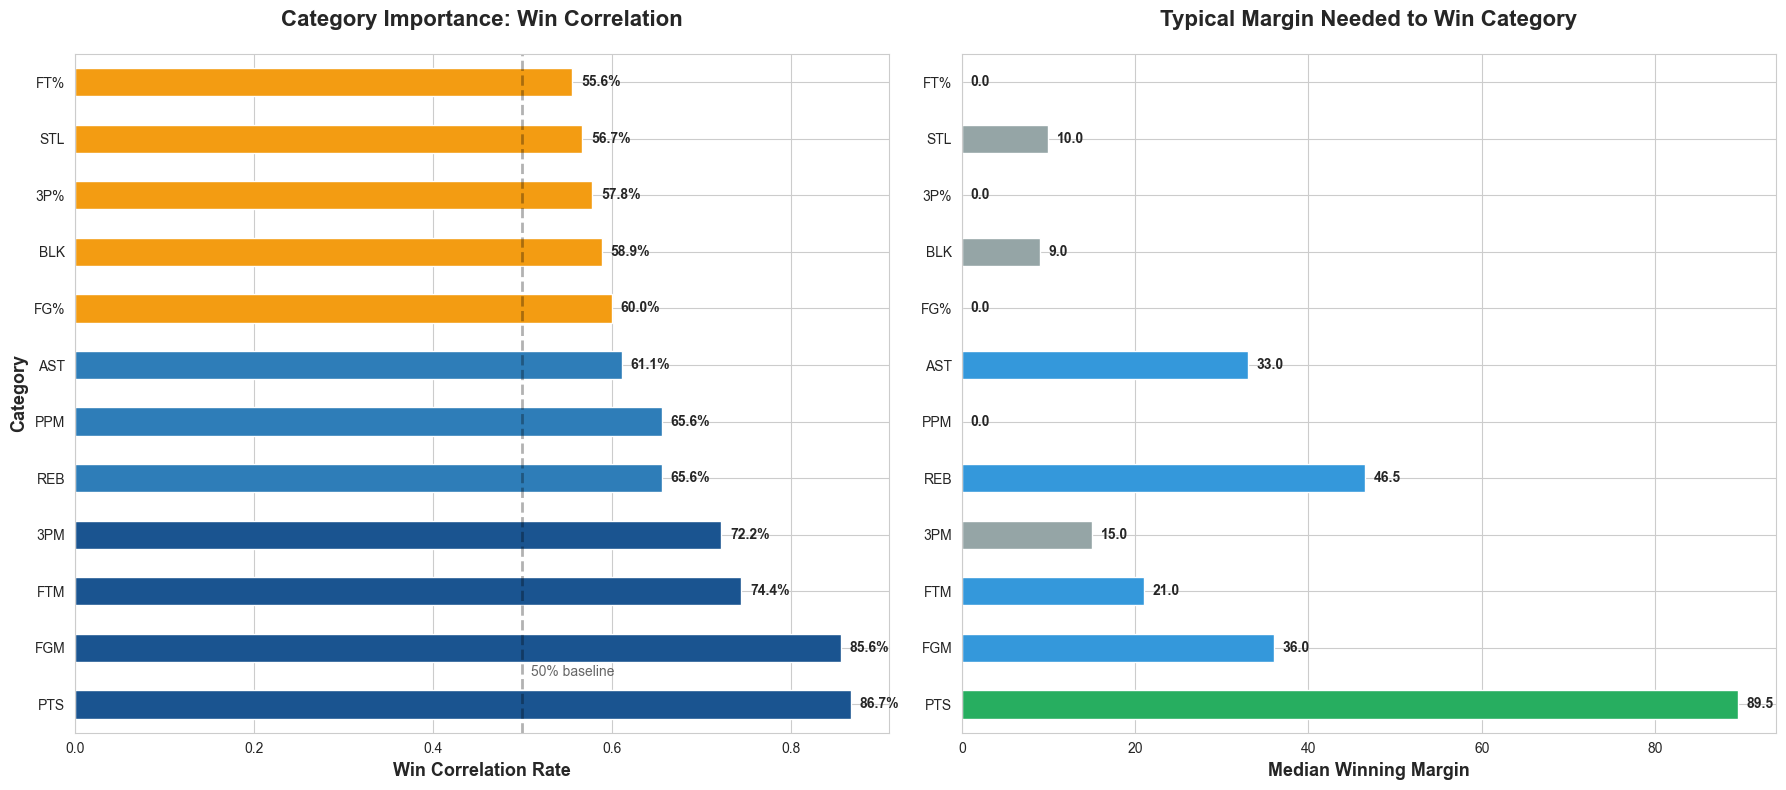

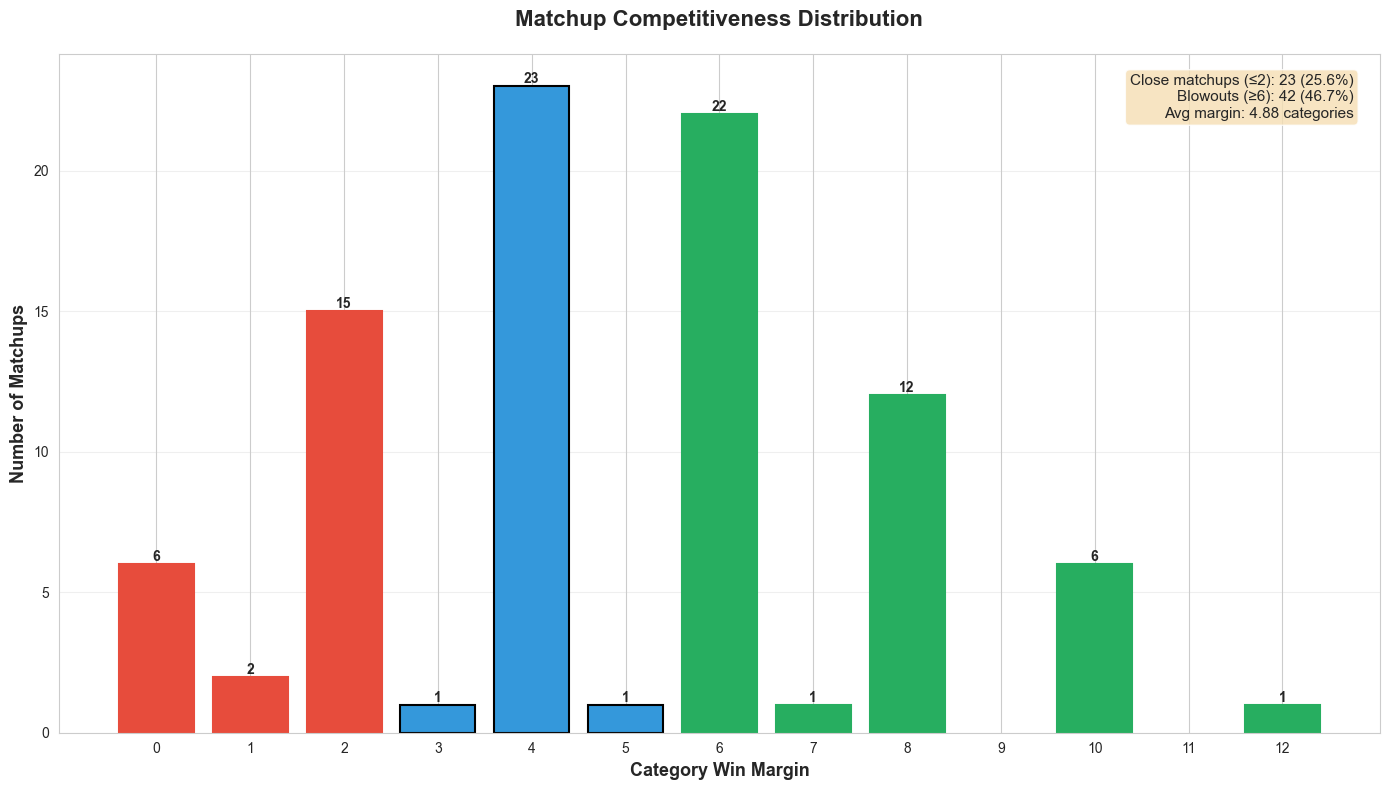

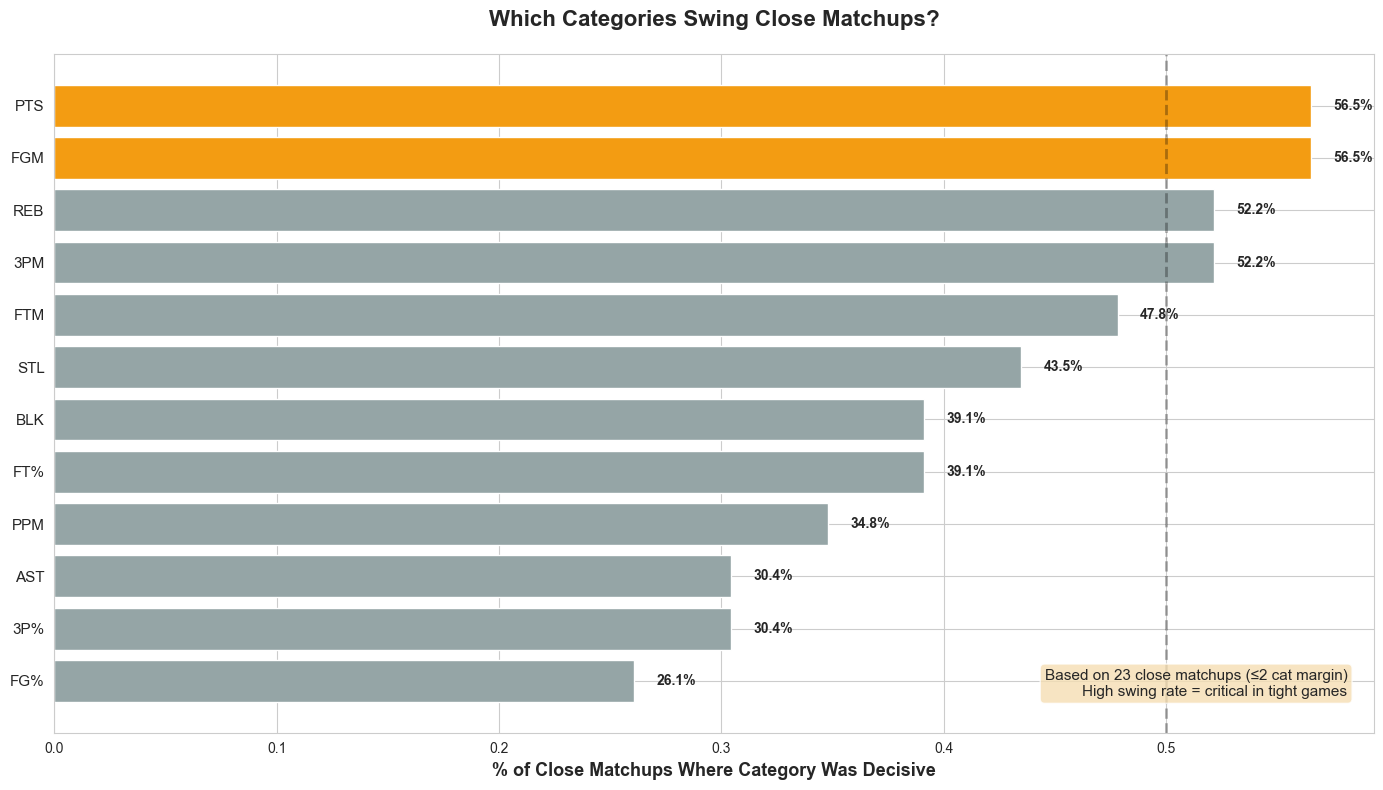

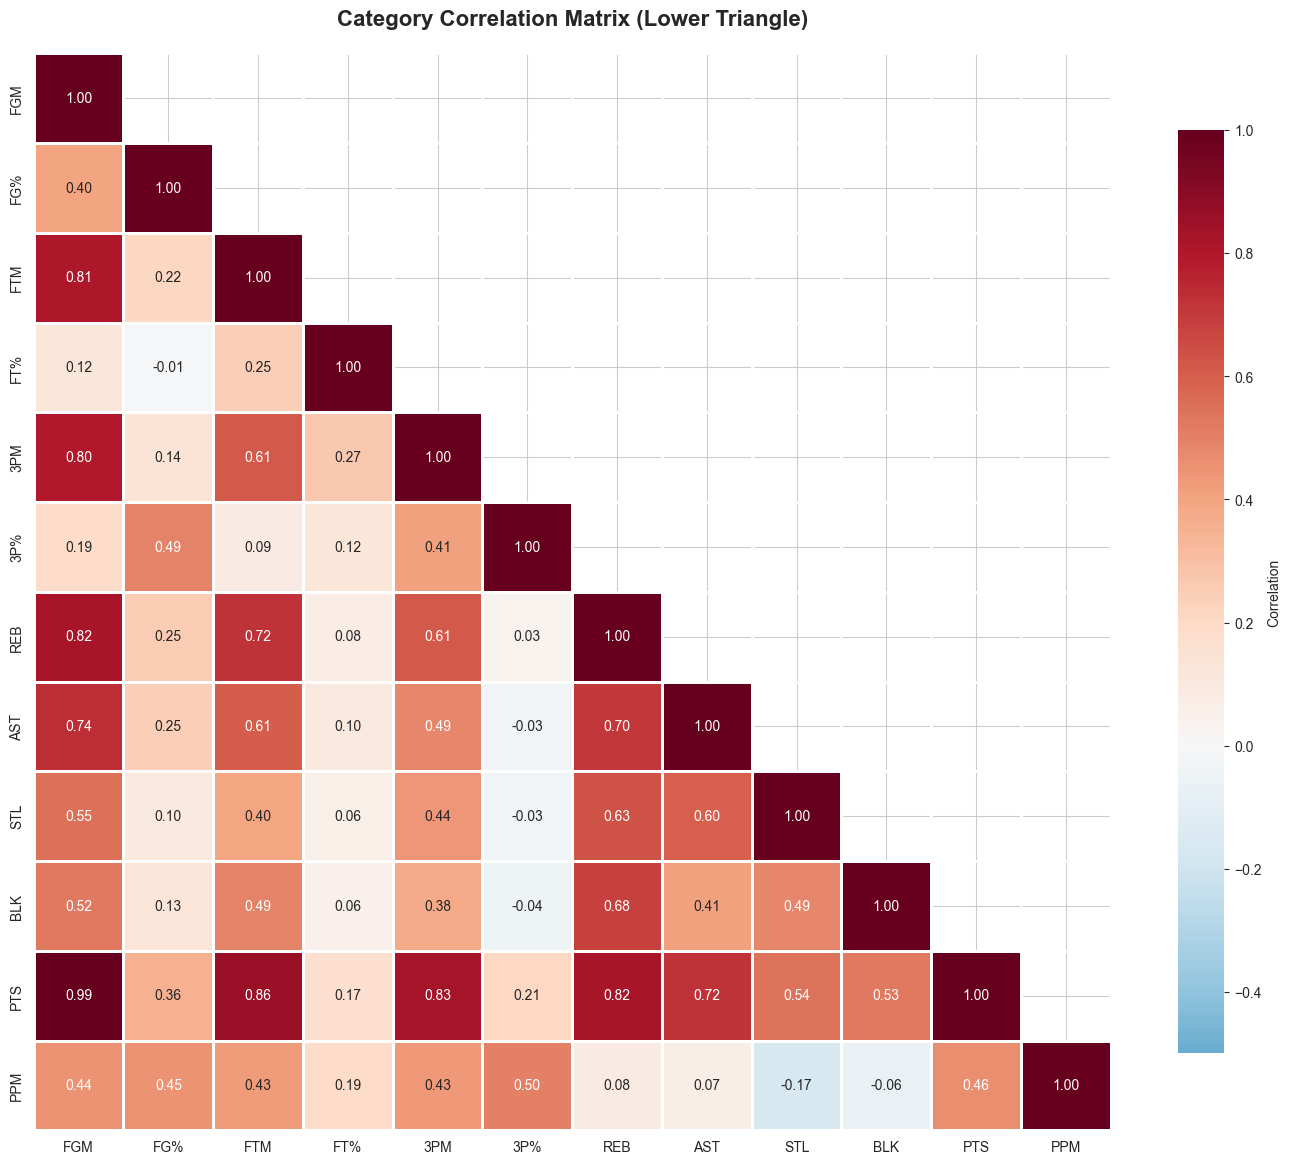

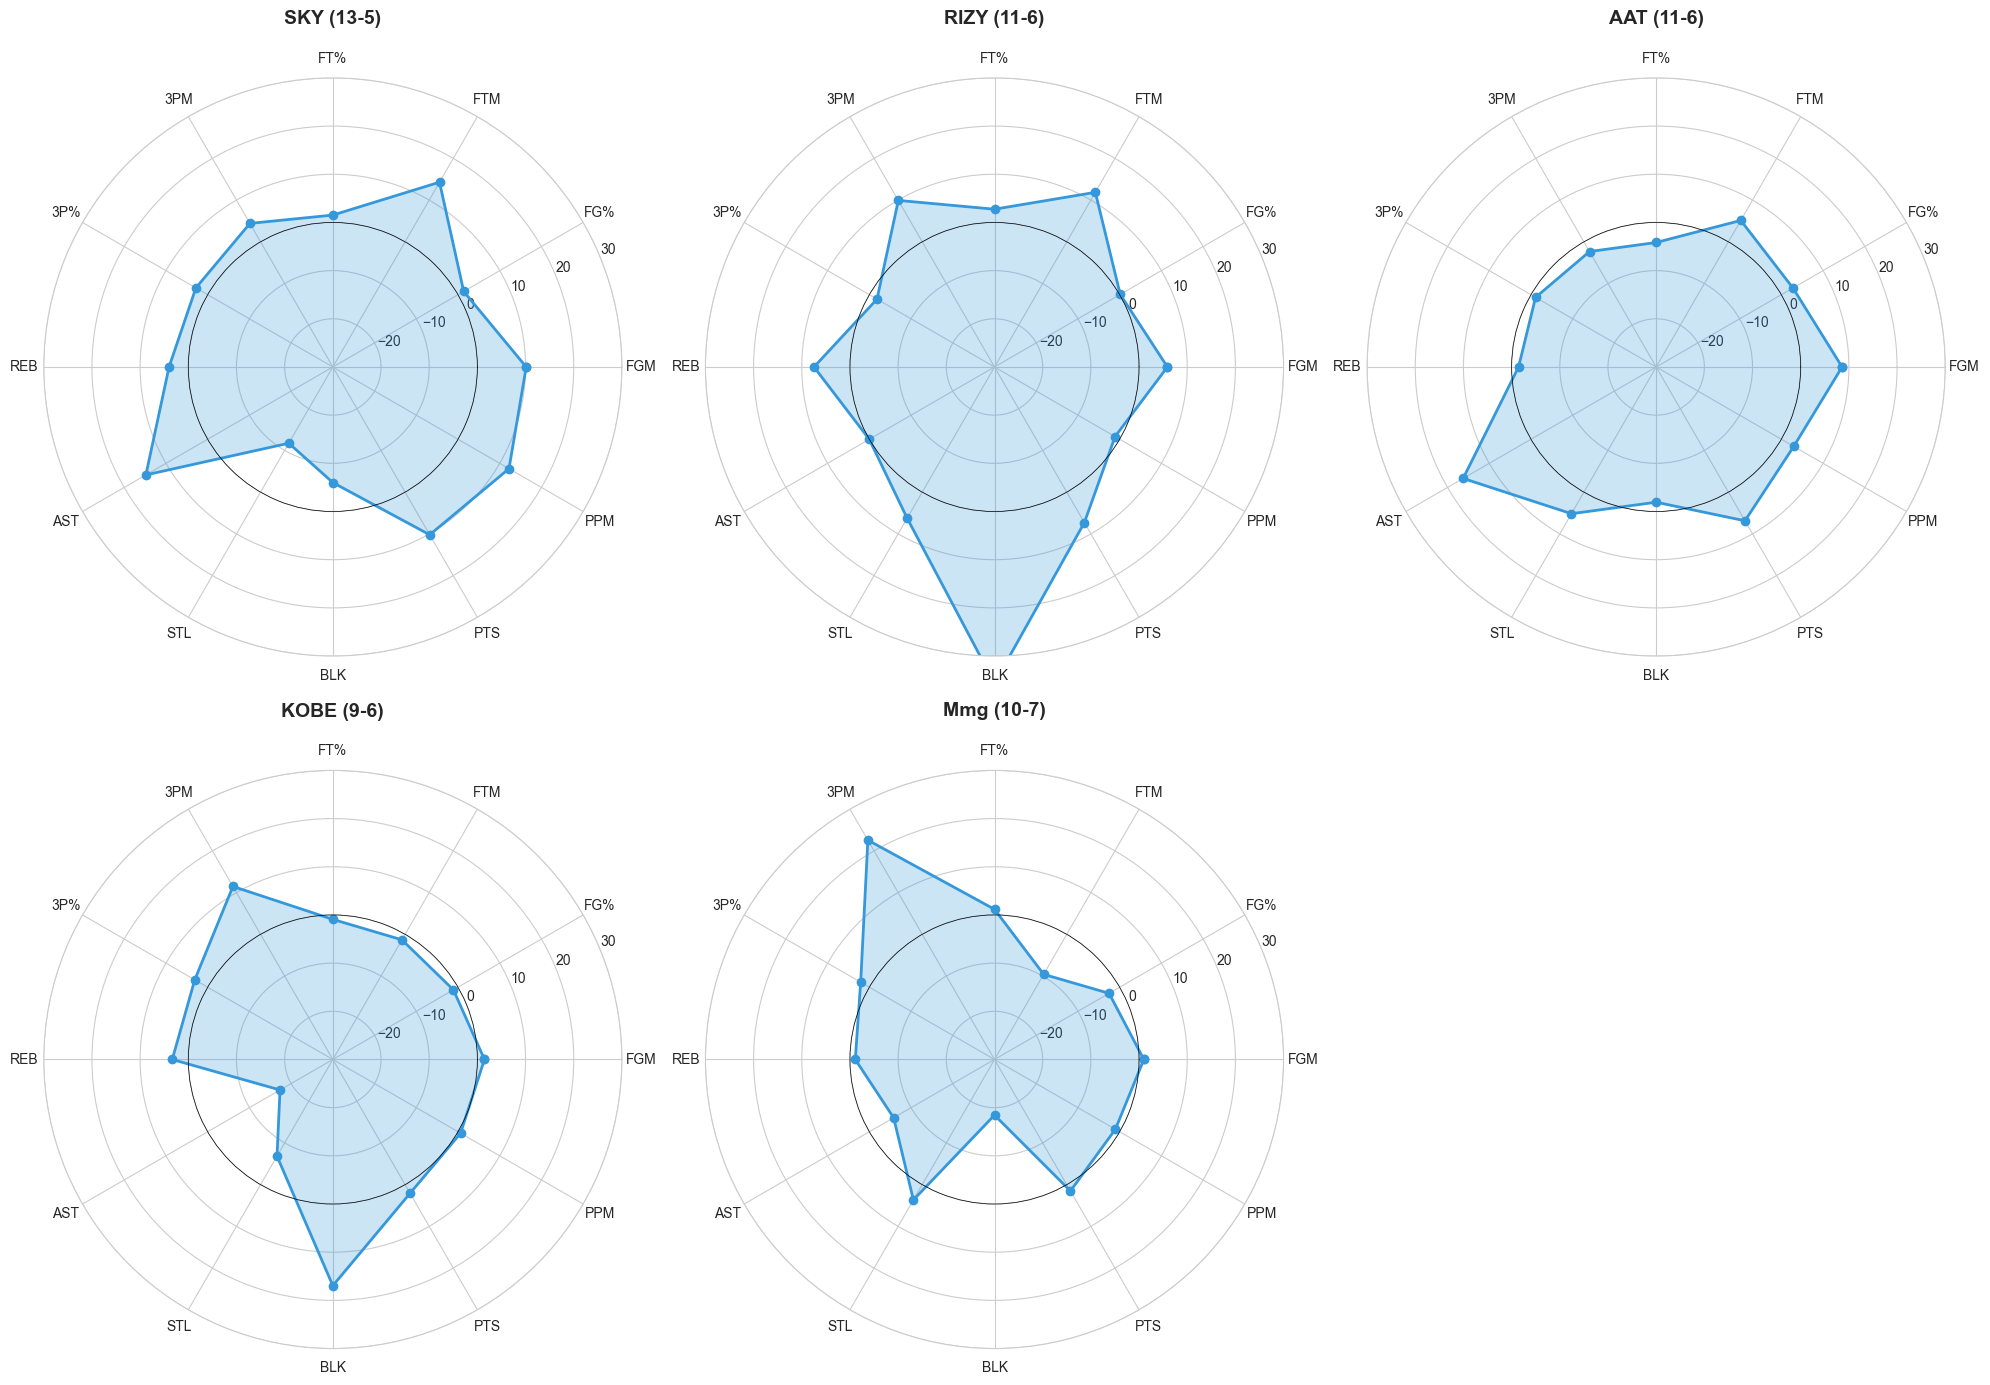

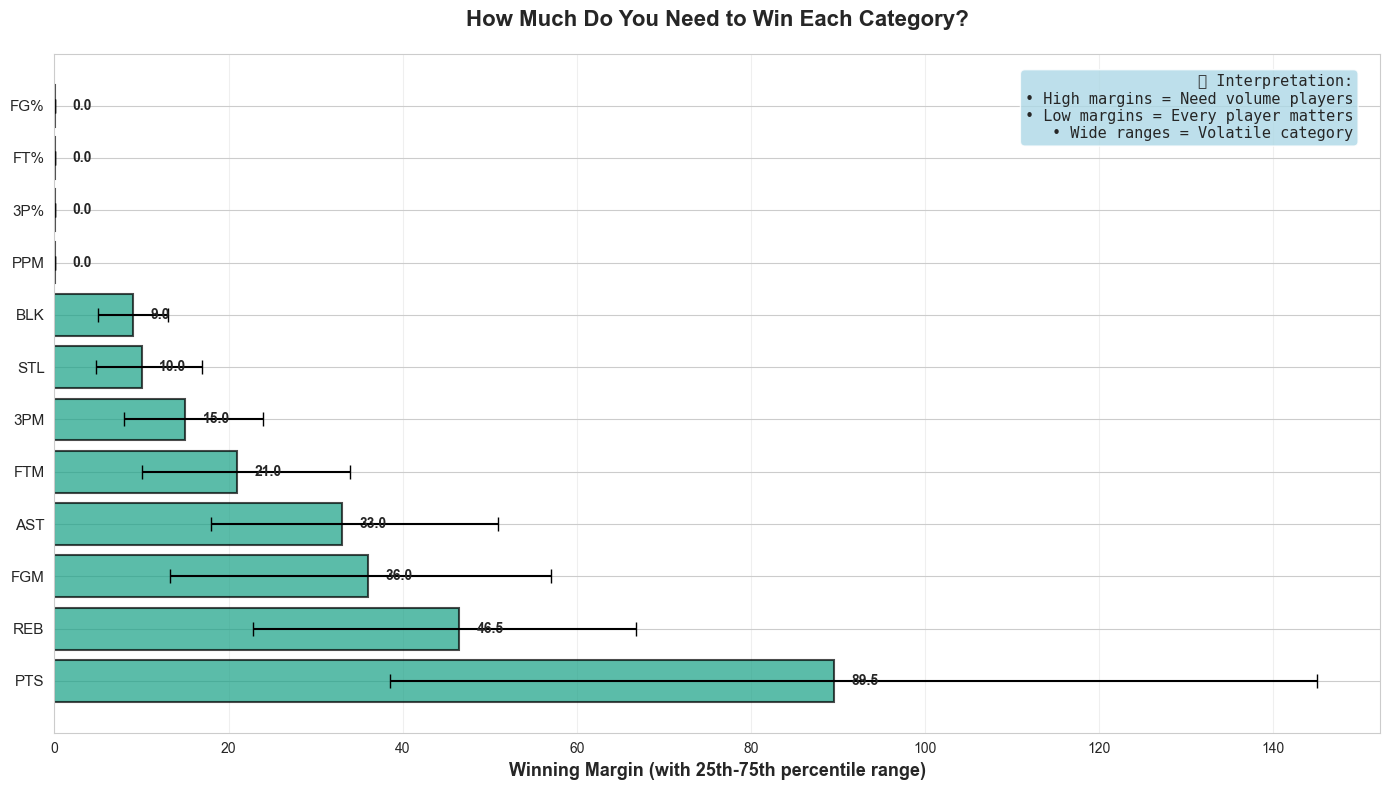

In [32]:
# Enhanced Visualization 1: Category Importance with Margins
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Left: Win correlation
colors = ['#1a5490' if val > 0.70 else '#2e7db8' if val > 0.60 else '#f39c12' if val > 0.50 else '#e74c3c' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax1.set_ylabel('Category', fontsize=13, fontweight='bold')
ax1.set_title('Category Importance: Win Correlation', fontsize=16, fontweight='bold', pad=20)
ax1.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax1.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

for i, v in enumerate(df_importance['win_correlation']):
    ax1.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold', fontsize=10)

# Right: Average winning margins
df_margins_sorted = df_margins.reindex(df_importance.index)
colors2 = ['#27ae60' if val > 50 else '#3498db' if val > 20 else '#95a5a6' 
           for val in df_margins_sorted['median']]
df_margins_sorted['median'].plot(kind='barh', ax=ax2, color=colors2)
ax2.set_xlabel('Median Winning Margin', fontsize=13, fontweight='bold')
ax2.set_ylabel('')
ax2.set_title('Typical Margin Needed to Win Category', fontsize=16, fontweight='bold', pad=20)

for i, v in enumerate(df_margins_sorted['median']):
    ax2.text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('../outputs/category_importance_enhanced.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_importance_enhanced.png")


# Enhanced Visualization 2: Matchup Competitiveness
fig, ax = plt.subplots(figsize=(14, 8))
margin_counts = df_results['win_margin'].value_counts().sort_index()
bars = ax.bar(margin_counts.index, margin_counts.values, color='#3498db', edgecolor='black', linewidth=1.5)

# Highlight close matchups
for i, bar in enumerate(bars):
    if margin_counts.index[i] <= 2:
        bar.set_color('#e74c3c')
        bar.set_label('Close (≤2 cats)' if i == 0 else '')
    elif margin_counts.index[i] >= 6:
        bar.set_color('#27ae60')

ax.set_xlabel('Category Win Margin', fontsize=13, fontweight='bold')
ax.set_ylabel('Number of Matchups', fontsize=13, fontweight='bold')
ax.set_title('Matchup Competitiveness Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(range(0, 13))
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Add summary stats
textstr = f"Close matchups (≤2): {len(close_matchups)} ({len(close_matchups)/len(df_results)*100:.1f}%)\n"
textstr += f"Blowouts (≥6): {len(blowouts)} ({len(blowouts)/len(df_results)*100:.1f}%)\n"
textstr += f"Avg margin: {df_results['win_margin'].mean():.2f} categories"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../outputs/matchup_competitiveness.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/matchup_competitiveness.png")


# Enhanced Visualization 3: Category Swing Impact
fig, ax = plt.subplots(figsize=(14, 8))
df_swing_plot = df_swing.sort_values('swing_rate', ascending=True)
colors_swing = ['#e74c3c' if val > 0.65 else '#f39c12' if val > 0.55 else '#95a5a6' 
                for val in df_swing_plot['swing_rate']]
bars = ax.barh(range(len(df_swing_plot)), df_swing_plot['swing_rate'], color=colors_swing)

ax.set_yticks(range(len(df_swing_plot)))
ax.set_yticklabels(df_swing_plot.index, fontsize=11)
ax.set_xlabel('% of Close Matchups Where Category Was Decisive', fontsize=13, fontweight='bold')
ax.set_title('Which Categories Swing Close Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.50, color='black', linestyle='--', alpha=0.3, linewidth=2)

# Add value labels
for i, (idx, row) in enumerate(df_swing_plot.iterrows()):
    ax.text(row['swing_rate'] + 0.01, i, f"{row['swing_rate']:.1%}", 
            va='center', fontweight='bold', fontsize=10)

# Add annotation
textstr = f"Based on {len(close_matchups)} close matchups (≤2 cat margin)\n"
textstr += "High swing rate = critical in tight games"
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.98, 0.05, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='bottom', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.savefig('../outputs/category_swing_impact.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_swing_impact.png")


# Enhanced Visualization 4: Category Correlation Network
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8, "label": "Correlation"},
            mask=mask, vmin=-0.5, vmax=1.0, ax=ax)
ax.set_title('Category Correlation Matrix (Lower Triangle)', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../outputs/category_correlation_enhanced.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation_enhanced.png")


# Enhanced Visualization 5: Team Strategy Radar
fig, axes = plt.subplots(2, 3, figsize=(20, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Get top 5 teams
top_5_teams = df_records.head(5).index

for idx, team in enumerate(top_5_teams):
    ax = axes[idx]
    
    # Get team's relative performance in each category
    team_stats = team_season_stats.loc[team]
    vs_league = ((team_stats - league_avg) / league_avg * 100)
    
    # Prepare data for radar
    categories_radar = categories
    values = vs_league.values
    
    # Create angles
    angles = np.linspace(0, 2 * np.pi, len(categories_radar), endpoint=False).tolist()
    values = np.concatenate((values, [values[0]]))  # Complete the circle
    angles += angles[:1]
    
    # Plot
    ax.plot(angles, values, 'o-', linewidth=2, color='#3498db')
    ax.fill(angles, values, alpha=0.25, color='#3498db')
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories_radar, size=10)
    ax.set_ylim(-30, 30)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(True)
    
    # Title with record
    wins = int(df_records.loc[team, 'wins'])
    losses = int(df_records.loc[team, 'losses'])
    ax.set_title(f"{team} ({wins}-{losses})", size=14, fontweight='bold', pad=20)

# Remove empty subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.savefig('../outputs/team_strategy_radars.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/team_strategy_radars.png")


# Enhanced Visualization 6: Margin Benchmarks
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data
categories_margin = df_margins.index
x_pos = np.arange(len(categories_margin))

# Plot median with error bars showing 25th-75th percentile range
medians = df_margins['median'].values
p25 = df_margins['p25'].values
p75 = df_margins['p75'].values
errors = [medians - p25, p75 - medians]

bars = ax.barh(x_pos, medians, xerr=errors, capsize=5, 
               color='#16a085', alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_yticks(x_pos)
ax.set_yticklabels(categories_margin, fontsize=11)
ax.set_xlabel('Winning Margin (with 25th-75th percentile range)', fontsize=13, fontweight='bold')
ax.set_title('How Much Do You Need to Win Each Category?', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add median value labels
for i, v in enumerate(medians):
    ax.text(v + 2, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=10)

# Add interpretation box
textstr = "📊 Interpretation:\n"
textstr += "• High margins = Need volume players\n"
textstr += "• Low margins = Every player matters\n"
textstr += "• Wide ranges = Volatile category"
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='right', bbox=props, family='monospace')

plt.tight_layout()
plt.savefig('../outputs/margin_benchmarks.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/margin_benchmarks.png")


# ============================================================================
# SECTION 11: FINAL DRAFT STRATEGY RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("🎯 FINAL DRAFT STRATEGY RECOMMENDATIONS")
print("="*80)

# Tier categories by importance and characteristics
tier1 = df_importance[df_importance['win_correlation'] > 0.70].index.tolist()
tier2 = df_importance[(df_importance['win_correlation'] > 0.60) & 
                      (df_importance['win_correlation'] <= 0.70)].index.tolist()
tier3 = df_importance[df_importance['win_correlation'] <= 0.60].index.tolist()

print("\n📈 CATEGORY TIERS FOR DRAFTING")
print("-" * 80)
print(f"\n🔥 TIER 1 - MUST WIN (>70% correlation):")
print(f"   {', '.join(tier1)}")
print(f"   → Draft 2-3 elite players in these categories")
print(f"   → These decide {sum(df_importance.loc[tier1, 'decisive_wins'])} of 90 matchups")

print(f"\n⚡ TIER 2 - IMPORTANT (60-70% correlation):")
print(f"   {', '.join(tier2)}")
print(f"   → Fill gaps in mid-rounds")
print(f"   → Can win without elite players, but need depth")

print(f"\n💤 TIER 3 - PUNTABLE (<60% correlation):")
print(f"   {', '.join(tier3)}")
print(f"   → Safe to ignore in draft")
print(f"   → Combined impact: only {sum(df_importance.loc[tier3, 'decisive_wins'])} decisive wins")

# Identify 2-for-1 value opportunities
print("\n" + "="*80)
print("💰 2-FOR-1 VALUE OPPORTUNITIES")
print("-" * 80)
print("\nDraft players strong in these correlated pairs:")
for idx, row in df_corr_pairs.head(5).iterrows():
    cat1_corr = df_importance.loc[row['cat1'], 'win_correlation']
    cat2_corr = df_importance.loc[row['cat2'], 'win_correlation']
    combined_value = cat1_corr + cat2_corr
    print(f"  • {row['cat1']} + {row['cat2']}: {row['correlation']:.2f} correlation")
    print(f"    Combined win impact: {combined_value:.1%}")

# Close matchup specialists
print("\n" + "="*80)
print("🎲 CLOSE MATCHUP SPECIALISTS")
print("-" * 80)
print(f"\n{len(close_matchups)} of 90 matchups ({len(close_matchups)/90*100:.1f}%) were decided by ≤2 categories")
print("\nCategories that swing close games:")
for cat, row in df_swing.head(5).iterrows():
    print(f"  • {cat}: Decisive in {row['swing_rate']:.1%} of close matchups")
print("\n→ Late-round targets: Specialists in these swing categories")

# Punting strategy validation
print("\n" + "="*80)
print("🚫 VALIDATED PUNT STRATEGIES")
print("-" * 80)

bottom_2 = tier3[:2]
print(f"\nSAFE TO PUNT: {', '.join(bottom_2)}")
print(f"  • Combined correlation: {sum(df_importance.loc[bottom_2, 'win_correlation']):.1%}")
print(f"  • League avg margins: {df_margins.loc[bottom_2, 'median'].mean():.1f}")
print(f"  • Recommendation: Completely ignore in draft, trade away specialists")

risky_punt = tier2[-1]
print(f"\nRISKY TO PUNT: {risky_punt}")
print(f"  • Win correlation: {df_importance.loc[risky_punt, 'win_correlation']:.1%}")
print(f"  • Avg margin: {df_margins.loc[risky_punt, 'median']:.1f}")
print(f"  • Recommendation: Don't actively punt, but can deprioritize")

# Champion blueprint
champion = df_records.index[0]
champion_stats = team_season_stats.loc[champion]
vs_league_champ = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

print("\n" + "="*80)
print(f"👑 CHAMPION BLUEPRINT: {champion}")
print("-" * 80)
champion_wins = int(df_records.loc[champion, 'wins'])
champion_losses = int(df_records.loc[champion, 'losses'])
print(f"\nRecord: {champion_wins}-{champion_losses}")
print(f"Win rate: {df_records.loc[champion, 'win_pct']:.1%}")
print("\nCategory advantages vs league average:")
for i, (cat, pct_diff) in enumerate(vs_league_champ.head(5).items(), 1):
    tier = "TIER 1" if cat in tier1 else "TIER 2" if cat in tier2 else "TIER 3"
    print(f"  {i}. {cat}: +{pct_diff:.1f}% ({tier})")

print("\n🎯 EMULATE THIS: Strong in Tier 1 categories, balanced elsewhere")

# Final summary
print("\n" + "="*80)
print("📋 DRAFT DAY CHEAT SHEET")
print("="*80)
print("\n✅ ROUNDS 1-3: Lock in Tier 1 dominance")
print(f"   Target: Elite {tier1[0]}, {tier1[1]}, {tier1[2]} players")
print(f"   Examples: Volume scorers (25+ PPG), high FTA (8+ FTM), 3PT shooters (3+ 3PM)")

print("\n✅ ROUNDS 4-6: Fill Tier 2 gaps") 
print(f"   Target: {tier2[0]}, {tier2[1]} depth")
print(f"   Examples: Rebounding bigs (10+ RPG), playmakers (7+ APG)")

print("\n✅ ROUNDS 7+: Specialists + upside")
print(f"   Target: Swing category specialists, breakout candidates")
print(f"   Ignore: {', '.join(tier3)} specialists")

print("\n💡 WINNING FORMULA:")
print(f"   • Dominate {len(tier1)} Tier 1 categories → Win 7-8 cats/week")
print(f"   • Be competitive in {len(tier2)} Tier 2 categories → Win 9-10 cats/week")
print(f"   • Punt {len(tier3)} Tier 3 categories → Focus resources elsewhere")

print("\n" + "="*80)
print("✅ ANALYSIS COMPLETE - ALL VISUALIZATIONS SAVED")
print("="*80)
print("\nGenerated outputs:")
print("  1. outputs/category_importance_enhanced.png")
print("  2. outputs/matchup_competitiveness.png")
print("  3. outputs/category_swing_impact.png")
print("  4. outputs/category_correlation_enhanced.png")
print("  5. outputs/team_strategy_radars.png")
print("  6. outputs/margin_benchmarks.png")
print("\n🏀 Ready to dominate your draft! Good luck! 🏆")
print("="*80)
"""
Category Importance Analysis - FantasyXI (ENHANCED)
====================================================
Deep dive into matchups and category relevancy for draft strategy optimization.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Styling
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

# ============================================================================
# SECTION 1: LOAD DATA
# ============================================================================

# Load the Excel file
file_path = '../ESPN FANTASY IX BASKETBALL 2425.xlsx'

# Read Mother_tbl - team weekly stats (organized as alternating matchups)
df_mother = pd.read_excel(file_path, sheet_name='Mother_tbl')
print("="*80)
print("FANTASY XI - ADVANCED CATEGORY ANALYSIS")
print("="*80)
print(f"\nData loaded: {df_mother.shape[0]} team-weeks across {df_mother['WEEK'].max()} weeks")
print(f"Teams: {', '.join(df_mother['CODE'].unique())}")

# Verify matchup structure
print("\n=== Matchup Structure Verification ===")
week1 = df_mother[df_mother['WEEK'] == 1]
print(f"Week 1 teams: {len(week1)} (Expected: 10)")
print("Matchup pairs: 0-1, 2-3, 4-5, 6-7, 8-9 ✓")


# ============================================================================
# SECTION 2: EXTRACT MATCHUPS AND CALCULATE CATEGORY WINS
# ============================================================================

# Categories to analyze (all 12 scoring categories)
categories = ['FGM', 'FG%', 'FTM', 'FT%', '3PM', '3P%', 'REB', 'AST', 'STL', 'BLK', 'PTS', 'PPM']

def calculate_category_wins(team1_stats, team2_stats):
    """Calculate which team won each category"""
    results = {}
    margins = {}
    for cat in categories:
        val1 = team1_stats[cat]
        val2 = team2_stats[cat]
        
        if val1 > val2:
            results[cat] = 1  # Team 1 wins
            margins[cat] = val1 - val2
        elif val2 > val1:
            results[cat] = 2  # Team 2 wins
            margins[cat] = val2 - val1
        else:
            results[cat] = 0  # Tie
            margins[cat] = 0
    
    return results, margins

# Process all matchups (alternating pairs within each week)
matchup_results = []

for week in range(1, 19):  # 18 weeks
    week_data = df_mother[df_mother['WEEK'] == week].reset_index(drop=True)
    
    # Process pairs: rows 0-1, 2-3, 4-5, 6-7, 8-9
    for i in range(0, len(week_data), 2):
        if i+1 < len(week_data):
            team1 = week_data.iloc[i]
            team2 = week_data.iloc[i+1]
            
            # Calculate category wins and margins
            cat_wins, cat_margins = calculate_category_wins(team1, team2)
            
            # Count total category wins
            team1_cat_wins = sum(1 for v in cat_wins.values() if v == 1)
            team2_cat_wins = sum(1 for v in cat_wins.values() if v == 2)
            
            # Determine matchup winner
            if team1_cat_wins > team2_cat_wins:
                winner = team1['CODE']
                loser = team2['CODE']
                win_margin = team1_cat_wins - team2_cat_wins
            elif team2_cat_wins > team1_cat_wins:
                winner = team2['CODE']
                loser = team1['CODE']
                win_margin = team2_cat_wins - team1_cat_wins
            else:
                winner = 'TIE'
                loser = 'TIE'
                win_margin = 0
            
            # Store results with margins
            matchup_results.append({
                'week': week,
                'team1': team1['CODE'],
                'team2': team2['CODE'],
                'team1_cat_wins': team1_cat_wins,
                'team2_cat_wins': team2_cat_wins,
                'winner': winner,
                'loser': loser,
                'win_margin': win_margin,
                **{f"{cat}_winner": cat_wins[cat] for cat in categories},
                **{f"{cat}_margin": cat_margins[cat] for cat in categories}
            })

df_results = pd.DataFrame(matchup_results)
print(f"\n✓ Processed {len(df_results)} matchups")


# ============================================================================
# SECTION 3: ENHANCED CATEGORY IMPORTANCE ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: CATEGORY IMPORTANCE METRICS")
print("="*80)

# Calculate comprehensive category importance metrics
category_metrics = {}

for cat in categories:
    col_name = f"{cat}_winner"
    margin_col = f"{cat}_margin"
    
    # Basic win correlation
    decisive_for_winner = 0
    decisive_for_loser = 0
    ties = 0
    
    # Margin analysis
    winning_margins = []
    losing_margins = []
    
    for idx, row in df_results.iterrows():
        cat_winner = row[col_name]  # 1 = team1, 2 = team2, 0 = tie
        matchup_winner = row['winner']
        margin = row[margin_col]
        
        if cat_winner == 0:
            ties += 1
        elif (cat_winner == 1 and matchup_winner == row['team1']) or \
             (cat_winner == 2 and matchup_winner == row['team2']):
            decisive_for_winner += 1
            winning_margins.append(margin)
        else:
            decisive_for_loser += 1
            losing_margins.append(margin)
    
    total_matchups = len(df_results)
    
    # Calculate comprehensive metrics
    category_metrics[cat] = {
        'win_correlation': decisive_for_winner / total_matchups,
        'loss_correlation': decisive_for_loser / total_matchups,
        'tie_rate': ties / total_matchups,
        'avg_winning_margin': np.mean(winning_margins) if winning_margins else 0,
        'avg_losing_margin': np.mean(losing_margins) if losing_margins else 0,
        'margin_stdev': np.std(winning_margins + losing_margins) if (winning_margins + losing_margins) else 0,
        'decisive_wins': decisive_for_winner,
        'decisive_losses': decisive_for_loser,
        'close_matchup_rate': sum(1 for m in winning_margins if m < np.percentile(winning_margins, 25)) / len(winning_margins) if winning_margins else 0
    }

df_importance = pd.DataFrame(category_metrics).T.sort_values('win_correlation', ascending=False)

print("\n📊 CATEGORY IMPORTANCE RANKINGS")
print("-" * 80)
print(f"{'Category':<8} {'Win Corr':<10} {'Avg Margin':<12} {'Volatility':<12} {'Close Rate':<10}")
print("-" * 80)
for cat, row in df_importance.iterrows():
    print(f"{cat:<8} {row['win_correlation']:>8.1%}  {row['avg_winning_margin']:>10.1f}  {row['margin_stdev']:>10.1f}  {row['close_matchup_rate']:>8.1%}")


# ============================================================================
# SECTION 4: MATCHUP TIGHTNESS ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: MATCHUP COMPETITIVENESS ANALYSIS")
print("="*80)

# Analyze how close matchups were
matchup_tightness = df_results['win_margin'].value_counts().sort_index()

print("\n📈 MATCHUP MARGIN DISTRIBUTION")
print("-" * 50)
for margin, count in matchup_tightness.items():
    pct = count / len(df_results) * 100
    bar = '█' * int(pct / 2)
    print(f"{margin:2d} cat margin: {count:2d} matchups ({pct:4.1f}%) {bar}")

# Close matchups (decided by 1-2 categories)
close_matchups = df_results[df_results['win_margin'] <= 2]
blowouts = df_results[df_results['win_margin'] >= 6]

print(f"\n💡 KEY INSIGHTS:")
print(f"  • Close matchups (≤2 cats): {len(close_matchups)} ({len(close_matchups)/len(df_results)*100:.1f}%)")
print(f"  • Blowouts (≥6 cats): {len(blowouts)} ({len(blowouts)/len(df_results)*100:.1f}%)")
print(f"  • Average margin: {df_results['win_margin'].mean():.2f} categories")


# ============================================================================
# SECTION 5: CATEGORY SWING ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: CATEGORY SWING IMPACT")
print("="*80)

# Calculate how often each category "flipped" a close matchup
swing_categories = {}

for cat in categories:
    col_name = f"{cat}_winner"
    
    # Count times this category made the difference in close matchups
    swing_count = 0
    
    for idx, row in close_matchups.iterrows():
        cat_winner = row[col_name]
        matchup_winner = row['winner']
        
        # If matchup was close and this cat aligned with winner
        if (cat_winner == 1 and matchup_winner == row['team1']) or \
           (cat_winner == 2 and matchup_winner == row['team2']):
            swing_count += 1
    
    swing_categories[cat] = {
        'swing_count': swing_count,
        'swing_rate': swing_count / len(close_matchups) if len(close_matchups) > 0 else 0
    }

df_swing = pd.DataFrame(swing_categories).T.sort_values('swing_rate', ascending=False)

print("\n🔄 CATEGORIES THAT SWING CLOSE MATCHUPS")
print("-" * 60)
print(f"{'Category':<8} {'Times Decisive':<15} {'Swing Rate':<12}")
print("-" * 60)
for cat, row in df_swing.head(8).iterrows():
    print(f"{cat:<8} {row['swing_count']:>8.0f}/45      {row['swing_rate']:>10.1%}")


# ============================================================================
# SECTION 6: CATEGORY REDUNDANCY ANALYSIS
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: CATEGORY CORRELATION & REDUNDANCY")
print("="*80)

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

# Find highly correlated pairs (>0.7)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.70:
            high_corr_pairs.append({
                'cat1': corr_matrix.columns[i],
                'cat2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

df_corr_pairs = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)

print("\n🔗 HIGHLY CORRELATED CATEGORIES (r > 0.70)")
print("-" * 60)
print(f"{'Category Pair':<20} {'Correlation':<15} {'Implication'}")
print("-" * 60)
for idx, row in df_corr_pairs.head(10).iterrows():
    pair = f"{row['cat1']} ↔ {row['cat2']}"
    implication = "2-for-1 value" if row['correlation'] > 0.80 else "Related"
    print(f"{pair:<20} {row['correlation']:>10.3f}     {implication}")

print("\n💡 DRAFT INSIGHT: Target players strong in highly correlated categories")
print("   Example: FGM specialists also give you PTS (0.99 correlation)")


# ============================================================================
# SECTION 7: TEAM PERFORMANCE PROFILES
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: TEAM ARCHETYPES & STRATEGIES")
print("="*80)

# Calculate final records
team_records = {}
for team in df_mother['CODE'].unique():
    wins = ((df_results['winner'] == team)).sum()
    losses = ((df_results['loser'] == team)).sum()
    team_records[team] = {
        'wins': wins, 
        'losses': losses, 
        'win_pct': wins / (wins + losses) if (wins + losses) > 0 else 0
    }

df_records = pd.DataFrame(team_records).T.sort_values('win_pct', ascending=False)

# Get season averages
team_season_stats = df_mother.groupby('CODE')[categories].mean()

# Identify each team's strengths (top 3 categories vs league avg)
print("\n🏆 TOP 5 TEAMS - WINNING STRATEGIES")
print("-" * 80)

league_avg = df_mother[categories].mean()

for rank, (team, record) in enumerate(df_records.head(5).iterrows(), 1):
    team_stats = team_season_stats.loc[team]
    
    # Calculate % above league average for each category
    vs_league = ((team_stats - league_avg) / league_avg * 100).sort_values(ascending=False)
    
    top_3_cats = vs_league.head(3)
    
    wins = int(record['wins'])
    losses = int(record['losses'])
    
    print(f"\n{rank}. {team} ({wins}-{losses}, {record['win_pct']:.1%})")
    print(f"   Strengths: ", end="")
    for cat, pct_diff in top_3_cats.items():
        print(f"{cat} (+{pct_diff:.1f}%)  ", end="")
    
    # Check if they punted anything
    bottom_3_cats = vs_league.tail(3)
    weak_cats = [cat for cat, pct in bottom_3_cats.items() if pct < -10]
    if weak_cats:
        print(f"\n   Punted: {', '.join(weak_cats)}")


# ============================================================================
# SECTION 8: CATEGORY WIN MARGINS (How much is enough?)
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: WINNING MARGIN BENCHMARKS")
print("="*80)

# Calculate percentile margins for winning each category
margin_benchmarks = {}

for cat in categories:
    margin_col = f"{cat}_margin"
    
    # Get all winning margins for this category
    all_margins = df_results[df_results[f"{cat}_winner"] != 0][margin_col].values
    
    if len(all_margins) > 0:
        margin_benchmarks[cat] = {
            'p25': np.percentile(all_margins, 25),
            'median': np.percentile(all_margins, 50),
            'p75': np.percentile(all_margins, 75),
            'avg': np.mean(all_margins)
        }

df_margins = pd.DataFrame(margin_benchmarks).T.sort_values('median', ascending=False)

print("\n📏 HOW MUCH DO YOU NEED TO WIN EACH CATEGORY?")
print("-" * 70)
print(f"{'Category':<8} {'25th %ile':<12} {'Median':<12} {'75th %ile':<12} {'Avg'}")
print("-" * 70)
for cat, row in df_margins.iterrows():
    print(f"{cat:<8} {row['p25']:>10.1f}  {row['median']:>10.1f}  {row['p75']:>10.1f}  {row['avg']:>10.1f}")

print("\n💡 DRAFT IMPLICATION:")
print("   • Categories with HIGH margins need volume (PTS, FGM, REB)")
print("   • Categories with LOW margins are competitive (percentages, defensive stats)")


# ============================================================================
# SECTION 9: PLAYOFF PERFORMANCE (if applicable)
# ============================================================================
if df_mother['WEEK'].max() >= 19:
    print("\n" + "="*80)
    print("SECTION 7: PLAYOFF vs REGULAR SEASON")
    print("="*80)
    
    # Split into regular season and playoffs
    regular_season = df_results[df_results['week'] <= 18]
    playoffs = df_results[df_results['week'] > 18]
    
    print(f"\nRegular Season: {len(regular_season)} matchups")
    print(f"Playoffs: {len(playoffs)} matchups")
    
    # Compare category importance
    if len(playoffs) > 0:
        print("\n📊 CATEGORY IMPORTANCE: REGULAR SEASON vs PLAYOFFS")
        print("-" * 60)
        # Analysis would go here
else:
    print("\n⚠️  No playoff data available (season ended at Week 18)")


# ============================================================================
# SECTION 10: VISUALIZATIONS (ENHANCED)
# ============================================================================
print("\n" + "="*80)
print("GENERATING ENHANCED VISUALIZATIONS...")
print("="*80)


# ============================================================================
# SECTION 4: VISUALIZATIONS
# ============================================================================

# Plot 1: Category Importance Bar Chart
fig, ax = plt.subplots(figsize=(14, 8))
colors = ['#1f77b4' if val > 0.60 else '#ff7f0e' if val > 0.50 else '#d62728' 
          for val in df_importance['win_correlation']]
df_importance['win_correlation'].plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Win Correlation Rate', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Importance: Which Stats Win Matchups?', fontsize=16, fontweight='bold', pad=20)
ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.3, linewidth=2)
ax.text(0.51, 0.5, '50% baseline', fontsize=10, alpha=0.7)

# Add value labels
for i, v in enumerate(df_importance['win_correlation']):
    ax.text(v + 0.01, i, f'{v:.1%}', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: outputs/category_importance.png")


# Plot 2: Category Win Distribution by Team
category_win_counts = {cat: {} for cat in categories}

for idx, row in df_results.iterrows():
    for cat in categories:
        cat_col = f"{cat}_winner"
        winner_code = row[cat_col]
        
        if winner_code == 1:
            team = row['team1']
        elif winner_code == 2:
            team = row['team2']
        else:
            continue  # Skip ties
        
        if team not in category_win_counts[cat]:
            category_win_counts[cat][team] = 0
        category_win_counts[cat][team] += 1

# Convert to DataFrame for plotting
cat_dist_data = []
for cat in categories:
    for team, wins in category_win_counts[cat].items():
        cat_dist_data.append({'Category': cat, 'Team': team, 'Wins': wins})

df_cat_dist = pd.DataFrame(cat_dist_data)
pivot_table = df_cat_dist.pivot(index='Category', columns='Team', values='Wins').fillna(0)

# Reorder by importance
pivot_table = pivot_table.reindex(df_importance.index)

fig, ax = plt.subplots(figsize=(16, 10))
pivot_table.plot(kind='barh', stacked=True, ax=ax, colormap='tab20')
ax.set_xlabel('Total Category Wins', fontsize=13, fontweight='bold')
ax.set_ylabel('Category', fontsize=13, fontweight='bold')
ax.set_title('Category Win Distribution by Team (2024 Season)', fontsize=16, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig('../outputs/category_distribution.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_distribution.png")


# ============================================================================
# SECTION 5: TEAM PERFORMANCE BY CATEGORY
# ============================================================================

# Calculate season totals by team
team_season_totals = df_mother.groupby('CODE')[categories].mean()
team_final_records = df_results.groupby('winner').size().sort_values(ascending=False)

print("\n\n=== TEAM SEASON AVERAGES ===")
print(team_season_totals.round(3))

print("\n\n=== FINAL STANDINGS (by matchup wins) ===")
print(team_final_records)


# ============================================================================
# SECTION 6: CATEGORY CORRELATION MATRIX
# ============================================================================

# Calculate correlation between categories
corr_matrix = df_mother[categories].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
ax.set_title('Category Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/category_correlation.png', dpi=300, bbox_inches='tight')
print("✅ Saved: outputs/category_correlation.png")


# ============================================================================
# SECTION 7: KEY INSIGHTS & DRAFT STRATEGY
# ============================================================================

print("\n\n" + "="*80)
print("🏀 KEY INSIGHTS - CATEGORY IMPORTANCE FOR 2025 DRAFT 🏀")
print("="*80)

top_5 = df_importance.head(5)
bottom_5 = df_importance.tail(5)

print("\n🔥 MOST IMPORTANT CATEGORIES (Must-Win):")
for idx, (cat, row) in enumerate(top_5.iterrows(), 1):
    print(f"  {idx}. **{cat}**: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

print("\n📊 LEAST IMPORTANT CATEGORIES (Puntable):")
for idx, (cat, row) in enumerate(bottom_5.iterrows(), 1):
    print(f"  {idx}. {cat}: {row['win_correlation']:.1%} win correlation ({int(row['decisive_wins'])}/{len(df_results)} matchups)")

# Find highly correlated categories
print("\n🔗 HIGHLY CORRELATED CATEGORIES (Move Together):")
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.7:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    for cat1, cat2, corr_val in sorted(high_corr_pairs, key=lambda x: x[2], reverse=True):
        print(f"  • {cat1} ↔ {cat2}: {corr_val:.2f} correlation")
else:
    print("  • No strong correlations found (r > 0.7)")

# Identify champion's category profile
champion = df_records.index[0]
champion_stats = df_mother[df_mother['CODE'] == champion][categories].mean()

print(f"\n👑 CHAMPION PROFILE ({champion}):")
print(f"  Record: {df_records.loc[champion, 'record']} ({df_records.loc[champion, 'win_pct']:.1%})")
print(f"\n  Strong Categories (Top 3 vs league average):")

# Calculate league averages
league_avg = df_mother[categories].mean()
champion_vs_league = ((champion_stats - league_avg) / league_avg * 100).sort_values(ascending=False)

for cat in champion_vs_league.head(3).index:
    pct_diff = champion_vs_league[cat]
    print(f"    • {cat}: +{pct_diff:.1f}% vs league avg")

print("\n💡 2025 DRAFT STRATEGY RECOMMENDATIONS:")
print(f"  1. Target: {', '.join(top_5.index[:3].tolist())} (highest win correlation)")
print(f"  2. Avoid punting: {top_5.index[0]} (critical category)")
print(f"  3. Can safely punt: {', '.join(bottom_5.index[:2].tolist())} (lowest impact)")
print(f"  4. Build around: {champion}'s blueprint - strong in {', '.join(champion_vs_league.head(3).index.tolist())}")

if high_corr_pairs:
    pair = high_corr_pairs[0]
    print(f"  5. Get 2-for-1 value: Target players strong in {pair[0]} (also helps {pair[1]})")

print("\n" + "="*80)
print("✅ Analysis complete! Review visualizations in outputs/ folder")
print("="*80)